In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
# Load a quick run_PCA function for later use

def create_groups(metadata, col, Components):
    condition_list = metadata[col].to_list()
    
    # Group data points by conditions for PCA plot labeling
    groups = {}
    for i, label in enumerate(condition_list):
        if label not in groups:
            groups[label] = []
        groups[label].append(Components[i])
    
    return groups

def run_PCA(df, standardize, n_components, metadata=None, plot_title=None, save_dir=None):
    """
    For quick use of PCA to asses normalization results of different normalization steps
    
    :param df: a pandas dataframe that has samples as columns and genes as rows
    :param standardize: whether to standardize the counts before pca, can be either True or False
    :param n_components: number of components for PCA, data type:int
    :param metadata: metadata is a dataframe that has samples as rows, "condition, sex, age, batch" as columns
    :param plot_title: title for saving PCA results, data type:str
    :param normalization_method: normalization method will only be used for plot save_name annotation, data type: str
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    # Drop NaN for PCA
    df = df.dropna()
    print(f"{len(df.index)} features are kept are NaN Removal")
    
    # Standardize the data for PCA
    if standardize == True:
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df.T)
    elif standardize == False:
        df_scaled = df.T
    else:
        print('standardise not defined, True or False is needed')
    
    # Run pca
    print(f'Running PCA with n_componenets={n_components}')
    pca = PCA(n_components=n_components)  
    principalComponents = pca.fit_transform(df_scaled)
    
    # Plot individual 
    plt.figure(figsize=(8, 6))
    for i in range(principalComponents.shape[0]):
        plt.scatter(principalComponents[i, 0], principalComponents[i, 1], alpha=0.7)  
        plt.annotate(df.columns[i],  
                     (principalComponents[i, 0], principalComponents[i, 1]),  
                     textcoords="offset points",  
                     xytext=(5,5),  
                     ha='center')  

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(plot_title)
    if save_dir == None:
        plt.show()
    else:
        plt.savefig(save_dir + '_colored_by_sample_id.pdf')
        plt.show()

    return principalComponents


def run_LDA(df, standardize, n_components, metadata, design_factor, plot_title=None, save_dir=None):
    """
    For quick use of LDA to assess normalization results of different normalization steps
    
    :param df: a pandas dataframe that has samples as columns and genes as rows
    :param standardize: whether to standardize the counts before LDA, can be either True or False
    :param n_components: number of components for LDA, data type: int
    :param metadata: metadata is a dataframe that has samples as rows, "condition, sex, age, batch" as columns
    :param plot_title: title for saving LDA results, data type: str
    :param normalization_method: normalization method will only be used for plot save_name annotation, data type: str
    
    :return: X_r2, lda
    """
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Ensure metadata matches the samples in df
    df = df.loc[:, metadata.index]
    
    # Drop NaN for LDA
    df = df.dropna()
    print(f"{len(df.index)} features are kept after NaN Removal")
    
    # Standardize the data for LDA
    if standardize == True:
        print('Caution: You should not standard scale LDA if you wish to apply this LDA result to transform other data!!!')
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df.T)
    elif standardize == False:
        df_scaled = df.T
    else:
        print('standardize not defined, True or False is needed')
        return None
    
    # Ensure metadata has the same samples as the dataframe
    if not all(metadata.index == df.columns):
        print('Metadata and data columns do not match!')
        return None

    # Run LDA
    print(f'Running LDA with n_components={n_components}')
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_r2 = lda.fit_transform(df_scaled, metadata[design_factor])
    
    return X_r2, lda

def run_RDA(df, standardize, n_components, metadata, design_factor, shrinkage='auto', plot_title=None, save_dir=None):
    """
    For quick use of RDA to assess normalization results of different normalization steps
    
    :param df: a pandas dataframe that has samples as columns and genes as rows
    :param standardize: whether to standardize the counts before RDA, can be either True or False
    :param n_components: number of components for RDA, data type: int
    :param metadata: metadata is a dataframe that has samples as rows, "condition, sex, age, batch" as columns
    :param shrinkage: shrinkage parameter for RDA, can be 'auto', None, or a float between 0 and 1
    :param plot_title: title for saving RDA results, data type: str
    :param normalization_method: normalization method will only be used for plot save_name annotation, data type: str
    
    :return: X_r2, rda
    """
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Ensure metadata matches the samples in df
    df = df.loc[:, metadata.index]
    
    # Drop NaN for RDA
    df = df.dropna()
    print(f"{len(df.index)} features are kept after NaN Removal")
    
    # Standardize the data for RDA
    if standardize == True:
        print('Caution: You should not standard scale RDA if you wish to apply this RDA result to transform other data!!!')
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df.T)
    elif standardize == False:
        df_scaled = df.T
    else:
        print('standardize not defined, True or False is needed')
        return None
    
    # Ensure metadata has the same samples as the dataframe
    if not all(metadata.index == df.columns):
        print('Metadata and data columns do not match!')
        return None

    # Run RDA
    print(f'Running RDA with n_components={n_components} and shrinkage={shrinkage}')
    rda = LinearDiscriminantAnalysis(n_components=n_components, shrinkage=shrinkage, solver='eigen')
    X_r2 = rda.fit_transform(df_scaled, metadata[design_factor])
    
    return X_r2, rda

In [3]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, algorithm='random_forest', **kwargs):
    """
    Train and evaluate a classifier using the specified algorithm.

    :param X_train: Training data features
    :param y_train: Training data labels
    :param X_test: Test data features
    :param y_test: Test data labels
    :param algorithm: The algorithm to use ('knn', 'random_forest', 'logistic_regression', 'svm')
    :param kwargs: Additional keyword arguments for the classifier
    :return: A tuple containing the accuracy of the classifier on the test set and the trained model
    """
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score
    
    # Select the classifier based on the chosen algorithm
    if algorithm == 'knn':
        model = KNeighborsClassifier(**kwargs)
    elif algorithm == 'random_forest':
        model = RandomForestClassifier(**kwargs)
    elif algorithm == 'logistic_regression':
        model = LogisticRegression(**kwargs)
    elif algorithm == 'svm':
        model = SVC(**kwargs)
    else:
        raise ValueError(f"Algorithm '{algorithm}' is not supported. Choose from 'knn', 'random_forest', 'logistic_regression', 'svm'.")

    # Train the classifier
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the classifier ({algorithm}):", accuracy)

    return accuracy, model

In [4]:
def read_gct(file_path):
    with open(file_path, 'r') as file:
        # Read the first two lines of gct file
        version = file.readline().strip()
        dimensions = file.readline().strip()
    
    # Read the GCT file, skipping the first two metadata rows
    df = pd.read_csv(file_path, sep='\t', skiprows=2)
    
    # Store first_2rows in a dictionary for gct file version check
    first_2rows = {
        "version": version,
        "dimensions": dimensions
    }
    
    return df, first_2rows

# dataframe reformating for excel read-in
def NameRows_Gene(df):
    df_data = df.iloc[: , 1:]
    df_label = df.iloc[:,0]
    df_data.index = df_label
    return df_data

# Identify saving directory for files during and after model train and testing

In [5]:
classification_savedir = '/Volumes/RNA_s2/Figure_2_outs/5_alternative_Final_VAT_Classification_model_with_GTEx/'

# Data processing, Training, and Application

## Batch effect correction of RNA-seq datasets
This step is critical to ensure that the GTEx data trained model can be applied to our WAT-MPS RNA-seq data. We will read in raw counts data of GTEx and our 4 day serum treated WAT-MPS RNA-seq samplesto find genes that have been robustly expressed in human adipose tissue and our WAT-MPS 'fat on chip'. 

In [7]:
# Read in GTEx data to dataframe
counts_save_dir = '/Volumes/RNA_s2/20240324_sexual_dimorphic_index/Downloads/bulkRNAseq/counts/'
GTEx_df, first_2rows = read_gct(counts_save_dir + 'gene_reads_2017-06-05_v8_adipose_visceral_omentum.gct')
GTEx_df =NameRows_Gene(GTEx_df)

# rename the columns (sample names) of GTEx_df with SUBJID in metadata
GTEx_df.columns = ['-'.join(col.split('-')[:2]) for col in GTEx_df.columns]
GTEx_df = NameRows_Gene(GTEx_df)
GTEx_gene_info_df = GTEx_df.iloc[:, [0]]  # Select the first column of df to make gene_info df
GTEx_df = NameRows_Gene(GTEx_df)
GTEx_df

,GTEX-1117F,GTEX-111CU,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-117YW,GTEX-117YX,GTEX-1192X,GTEX-11DXX,...,GTEX-ZVZP,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYFG,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZZ64,GTEX-ZZPU
Description,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
WASH7P,139,34,22,65,123,118,210,46,189,103,...,75,56,184,310,78,92,140,61,92,51
MIR6859-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
MIR1302-2HG,0,1,0,0,0,0,0,2,1,0,...,0,0,1,1,0,0,1,0,0,0
FAM138A,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,18938,232576,250632,353591,15891,27351,22013,189496,11929,217205,...,381483,321281,14352,41921,362538,24577,20715,21586,282567,168392
MT-TE,5,114,100,144,3,5,6,91,5,117,...,193,157,4,12,198,2,5,4,114,112
MT-CYB,402801,1281152,777144,1206372,389819,790793,548776,415965,224627,805661,...,1166963,1224359,249404,1665534,1394619,1028492,413022,332223,873162,506621


In [8]:
from pydeseq2.preprocessing import deseq2_norm

GTEx_norm = deseq2_norm(GTEx_df.T)
normalized_GTEx_df = GTEx_norm[0].T
normalized_GTEx_df

,GTEX-1117F,GTEX-111CU,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-117YW,GTEX-117YX,GTEX-1192X,GTEX-11DXX,...,GTEX-ZVZP,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYFG,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZZ64,GTEX-ZZPU
Description,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.098041,...,0.000000e+00,1.114883e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.087613,0.000000,0.000000e+00,0.000000
WASH7P,221.605735,4.272523e+01,28.061035,7.460896e+01,119.628929,138.620668,227.912025,49.344312,198.479440,113.098201,...,9.679651e+01,6.243344e+01,203.765720,2.957320e+02,7.766340e+01,86.325410,152.265834,62.720388,1.104414e+02,45.936428
MIR6859-1,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,9.539742e-01,0.000000e+00,0.000000,1.087613,0.000000,0.000000e+00,0.000000
MIR1302-2HG,0.000000,1.256624e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.145405,1.050156,0.000000,...,0.000000e+00,0.000000e+00,1.107422,9.539742e-01,0.000000e+00,0.000000,1.087613,0.000000,0.000000e+00,0.000000
FAM138A,0.000000,1.256624e+00,0.000000,0.000000e+00,0.000000,1.174751,1.085295,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.938320,0.000000,1.028203,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,30192.585709,2.922606e+05,319681.516410,4.058624e+05,15455.474024,32130.626166,23890.606686,203272.819099,12527.308144,238499.949253,...,4.923497e+05,3.581907e+05,15893.726140,3.999155e+04,3.609735e+05,23061.082737,22529.905409,22194.791557,3.392076e+05,151673.078037
MT-TE,7.971429,1.432552e+02,127.550160,1.652876e+02,2.917779,5.873757,6.511772,97.615921,5.250779,128.470772,...,2.490897e+02,1.750366e+02,4.429690,1.144769e+01,1.971456e+02,1.876639,5.438066,4.112812,1.368513e+02,100.879999
MT-CYB,642179.940660,1.609927e+06,991248.413565,1.384710e+06,379135.197809,928985.201927,595584.044653,446206.665029,235893.339462,884648.638915,...,1.506106e+06,1.365017e+06,276195.573739,1.588876e+06,1.388601e+06,965054.282714,449208.138630,341592.709875,1.048188e+06,456320.766237


In [9]:
# Read in 4 day serum treated WAT-MPS data to dataframe
day4_save_dir = '/Volumes/RNA_s2/Figure_2_outs/1.Count/'
serum_4day_df = pd.read_excel(day4_save_dir + 'gene_count.xlsx')
serum_4day_df =NameRows_Gene(serum_4day_df)

gene_info_df = pd.read_excel(day4_save_dir + 'gene_info.xlsx')
gene_info_df = NameRows_Gene(gene_info_df)

serum_4day_df.index = gene_info_df['gene_name'] # rename with official gene symbol
serum_4day_df

,MY1_1,MY1_2,MY1_3,MY1_ctrl,Fat_OM1_1,Fat_OM1_2,Fat_OM1_3,YF1_1,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
gene_name,,,,,,,,,,,,,,,,,,
FTL,650775,1006740,782492,418678,430234,398159,358284,665614,441232,672444,373510,481789,712699,681253,838003,595407,595624,479740
SCD,390924,829454,441286,201239,331301,326124,310017,314474,236898,337333,84930,405597,844178,642285,647883,349947,462090,173527
MT-ND4,367852,561842,338677,248266,137996,164048,173474,304420,216935,352173,121569,349281,397256,253819,384472,360596,341003,177595
MT-CO1,316994,428352,229208,360154,193141,221580,241880,267061,194723,286602,60835,284787,408146,226503,319392,357269,263981,108717
MT-ND2,158843,276268,220187,224258,125876,115018,97678,180032,143926,232737,104988,235900,209121,161997,260111,194547,223026,130330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF01973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RF01974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AC233755.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
from pydeseq2.preprocessing import deseq2_norm

serum_4day_norm = deseq2_norm(serum_4day_df.T)
normalized_serum_4day_df = serum_4day_norm[0].T
normalized_serum_4day_df

,MY1_1,MY1_2,MY1_3,MY1_ctrl,Fat_OM1_1,Fat_OM1_2,Fat_OM1_3,YF1_1,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
gene_name,,,,,,,,,,,,,,,,,,
FTL,896238.360036,797214.087979,799904.590633,445846.402502,438393.639061,406531.571267,382173.820013,630804.345579,515942.870136,550594.961934,469491.460192,452940.153348,624983.206323,682082.662316,623237.675865,644584.512768,497939.937627,474500.342822
SCD,538375.144495,656825.410861,451105.822401,214297.584762,337584.316940,332981.804123,330688.451505,298027.934766,277010.357475,276207.164157,106754.597505,381310.422981,740280.361200,643067.205232,481842.063993,378850.797000,386305.900666,171631.760931
MT-ND4,506600.704108,444909.666466,346213.491054,264376.210271,140613.174728,167497.635877,185040.976580,288499.729394,253667.155902,288358.107931,152808.779749,328366.545732,348363.514767,254128.112854,285938.637111,390379.348859,285077.519628,175655.330770
MT-CO1,436559.767510,339202.027350,234308.505914,383524.726035,196804.031857,226239.430884,258008.182293,253094.495210,227694.146167,234668.786219,76467.866940,267734.355603,357913.222451,226778.846130,237537.488255,386777.556011,220687.350870,107529.607226
MT-ND2,218756.390186,218770.230305,225086.763951,238810.308954,128263.311850,117436.622716,104191.017157,170616.855930,168296.029135,190564.299266,131966.933744,221774.640299,183383.326046,162194.287654,193449.158424,210615.567512,186449.089575,128906.552883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF01973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RF01974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC233755.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
# Concat the three datasets for normalization
## remove rows with duplicated labels for all three df
def remove_duplicate(df):
    duplicates = df.index.duplicated(keep=False)
    # Remove rows with duplicated index labels
    df_no_duplicates = df[~duplicates]
    return df_no_duplicates

normalized_GTEx_df = remove_duplicate(df=normalized_GTEx_df)
normalized_serum_4day_df = remove_duplicate(df=normalized_serum_4day_df)

## find common index
common_index = normalized_GTEx_df.index.intersection(normalized_serum_4day_df.index)

## Reindex all dataframes to the common index
GTEx_df_aligned = normalized_GTEx_df.reindex(common_index)
serum_4day_df_aligned = normalized_serum_4day_df.reindex(common_index)

## Concatenate the dataframes by columns
normalized_merged_df = pd.concat([GTEx_df_aligned, serum_4day_df_aligned], axis=1)
normalized_merged_df

,GTEX-1117F,GTEX-111CU,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-117YW,GTEX-117YX,GTEX-1192X,GTEX-11DXX,...,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
DDX11L1,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.098041,...,0.000000,0.000000,1.256972,0.940121,0.000000,0.000000,0.000000,0.000000,1.671994,1.978156
WASH7P,221.605735,4.272523e+01,28.061035,7.460896e+01,119.628929,138.620668,227.912025,49.344312,198.479440,113.098201,...,50.280903,65.503740,82.960125,71.449227,71.030884,74.090121,74.371771,43.303791,99.483655,170.121439
MIR6859-1,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.169323,4.912781,3.770915,4.700607,5.261547,7.008525,2.231153,5.412974,1.671994,0.989078
MIR1302-2HG,0.000000,1.256624e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.145405,1.050156,0.000000,...,0.000000,0.818797,0.000000,0.940121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FAM138A,0.000000,1.256624e+00,0.000000,0.000000e+00,0.000000,1.174751,1.085295,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,30192.585709,2.922606e+05,319681.516410,4.058624e+05,15455.474024,32130.626166,23890.606686,203272.819099,12527.308144,238499.949253,...,19097.388573,17752.332342,8526.038324,22263.955199,30941.403667,17847.709351,21235.371901,32629.406800,17513.303281,8483.323134
MT-TE,7.971429,1.432552e+02,127.550160,1.652876e+02,2.917779,5.873757,6.511772,97.615921,5.250779,128.470772,...,16.370527,15.557138,5.027886,22.562914,49.984696,17.020703,18.592943,22.734490,17.555939,12.858016
MT-CYB,642179.940660,1.609927e+06,991248.413565,1.384710e+06,379135.197809,928985.201927,595584.044653,446206.665029,235893.339462,884648.638915,...,86655.043780,105904.809273,68393.081418,123815.869761,135130.556043,96247.071688,107127.330743,152496.466514,102030.102259,69890.238930
MT-TT,1.594286,7.539746e+00,11.479514,8.034812e+00,0.000000,1.174751,0.000000,2.145405,0.000000,8.784326,...,4.677293,4.093984,1.256972,7.520971,10.523094,3.003654,5.206024,14.073732,5.851980,0.000000


36465 features are kept are NaN Removal
Running PCA with n_componenets=2


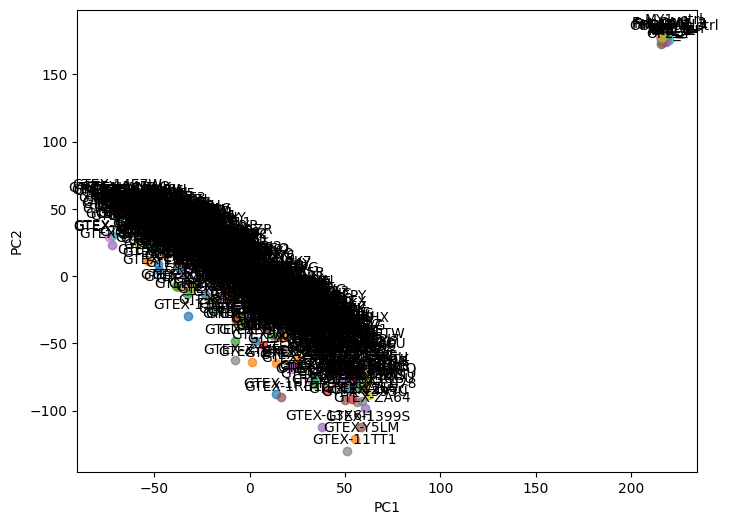

In [12]:
# Perform principle component analysis to visualize differences of human SAT and WAT-MPS
principalComponents = run_PCA(df=normalized_merged_df, standardize=True, n_components=2, 
                              metadata = None,
                              plot_title=None,
                              save_dir = None)

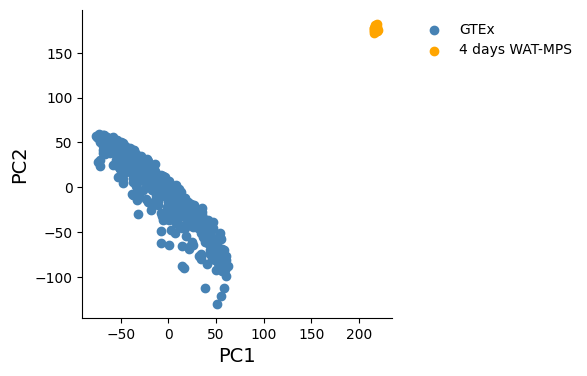

In [13]:
# Plot PCA with dataset origin as color
merged_metadata = pd.DataFrame()
batch_list = len(GTEx_df.columns.tolist())*['GTEx'] + len(serum_4day_df.columns.tolist())*['4 days WAT-MPS'] 
merged_metadata['batch'] = batch_list

# Plot PCA plot and color the dots by group
groups = create_groups(metadata = merged_metadata, 
                       col = 'batch', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'GTEx':'steelblue', '4 days WAT-MPS': 'orange'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

#plt.tight_layout()
plt.savefig(classification_savedir + 'Norm_counts/1_PCA_after_MOR.pdf', bbox_inches='tight')
plt.show()

As you can tell, the datasets exhibit enormous differences. In order to train a GTEx-based age prediction model, we will have to find genes that are robustly detected. Here, we employed Wilcoxon test to compare gene expression differences between human adipose tissue and WAT-MPS, and selected the not significantly changed genes.

In [14]:
# Adding a group label to all samples for later use (transpose the data for wald test)
GTEx_sample_list = normalized_GTEx_df.columns.tolist()
GTEx_counts_df = normalized_merged_df[GTEx_sample_list].T
GTEx_counts_df['group'] = 'GTEx'

serum_4day_sample_list = normalized_serum_4day_df.columns.tolist()
serum_4day_counts_df = normalized_merged_df[serum_4day_sample_list].T
serum_4day_counts_df['group'] = '4day_serum'

In [15]:
# Concatenate the dataframes
labeled_merged_df = pd.concat([GTEx_counts_df, serum_4day_counts_df])
labeled_merged_df

,DDX11L1,WASH7P,MIR6859-1,MIR1302-2HG,FAM138A,OR4G4P,OR4G11P,OR4F5,CICP27,RNU6-1100P,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,group
GTEX-1117F,0.000000,221.605735,0.000000,0.000000,0.000000,1.594286,0.000000,1.594286,0.000000,0.0,...,0.000000,0.000000,0.000000,1.446623e+05,30192.585709,7.971429,6.421799e+05,1.594286,4.782858,GTEx
GTEX-111CU,0.000000,42.725225,0.000000,1.256624,1.256624,1.256624,8.796370,5.026497,8.796370,0.0,...,8.796370,5.026497,10.052994,8.200843e+05,292260.646023,143.255167,1.609927e+06,7.539746,5.026497,GTEx
GTEX-111YS,0.000000,28.061035,0.000000,0.000000,0.000000,0.000000,2.551003,2.551003,1.275502,0.0,...,2.551003,1.275502,6.377508,7.510957e+05,319681.516410,127.550160,9.912484e+05,11.479514,3.826505,GTEx
GTEX-1122O,0.000000,74.608965,0.000000,0.000000,0.000000,1.147830,0.000000,1.147830,4.591321,0.0,...,18.365284,5.739151,67.721983,1.091090e+06,405862.437250,165.287552,1.384710e+06,8.034812,11.478302,GTEx
GTEX-1128S,0.000000,119.628929,0.000000,0.000000,0.000000,0.972593,0.000000,0.000000,1.945186,0.0,...,59.328168,0.000000,0.000000,7.728710e+04,15455.474024,2.917779,3.791352e+05,0.000000,0.000000,GTEx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OF2_2,0.000000,74.090121,7.008525,0.000000,0.000000,0.000000,0.000000,0.000000,1.001218,0.0,...,19.023139,5.006089,16.019486,5.035725e+04,17847.709351,17.020703,9.624707e+04,3.003654,1165.417575,4day_serum
OF2_4,0.000000,74.371771,2.231153,0.000000,0.000000,0.000000,0.000000,0.000000,4.462306,0.0,...,26.773838,11.155766,14.874354,5.731386e+04,21235.371901,18.592943,1.071273e+05,5.206024,1405.626480,4day_serum
OF2_ctrl,0.000000,43.303791,5.412974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,55.212334,16.238922,36.808223,9.068897e+04,32629.406800,22.734490,1.524965e+05,14.073732,1593.579523,4day_serum
FY2_1,1.671994,99.483655,1.671994,0.000000,0.000000,0.000000,0.000000,0.000000,1.671994,0.0,...,15.047948,9.195968,16.719942,5.779833e+04,17513.303281,17.555939,1.020301e+05,5.851980,996.508545,4day_serum


In [16]:
import scipy.stats as stats

# Identify the features (genes)
features = labeled_merged_df.columns.tolist()
features.pop()

results = {}
for feature in features:
    # Extract groups
    grouped = labeled_merged_df.groupby('group')[feature].apply(list)
    
    # Perform wilcoxon test to identify robust genes
    p_value = stats.mannwhitneyu(grouped['GTEx'], grouped['4day_serum']).pvalue
    # Store the p-values in a dictionary
    results[feature] = p_value  

# Convert results to a DataFrame for easier interpretation
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['p-value'])

# Sort the DataFrame by p-value in descending order
sorted_results_df = results_df.sort_values(by='p-value', ascending=False)

In [17]:
# Display features that are not significantly different across groups
non_significant_features = sorted_results_df[sorted_results_df['p-value'] > 0.05]
non_significant_features

,p-value
RNA5SP292,1.000000
SNORD115-31,1.000000
SNORD115-29,1.000000
MIR3116-1,1.000000
MLECP1,1.000000
...,...
MDFI,0.050305
NMUR2,0.050248
LINC00431,0.050223
RNU4-80P,0.050175


In [18]:
robust_normalized_counts_df = normalized_merged_df.loc[non_significant_features.index.tolist()]
robust_normalized_counts_df

,GTEX-1117F,GTEX-111CU,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-117YW,GTEX-117YX,GTEX-1192X,GTEX-11DXX,...,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
RNA5SP292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SNORD115-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SNORD115-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MIR3116-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MLECP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDFI,1200.497256,2823.634733,756.372447,5961.830191,1784.708000,451.104546,494.894683,1452.439086,2472.066675,1901.806644,...,1218.434907,982.5561,529.185041,1192.073946,1186.478833,1308.591727,944.521497,1296.948552,1007.376507,821.923927
NMUR2,0.000000,0.000000,1.275502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,2.513943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LINC00431,3.188572,5.026497,1.275502,1.147830,24.314823,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.169323,0.0000,0.000000,0.000000,0.876924,0.000000,1.487435,0.000000,0.000000,0.000000
RNU4-80P,3.188572,0.000000,0.000000,0.000000,0.000000,1.174751,0.000000,1.072702,3.150467,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,1.001218,0.000000,0.000000,0.000000,0.000000


12355 features are kept are NaN Removal
Running PCA with n_componenets=2


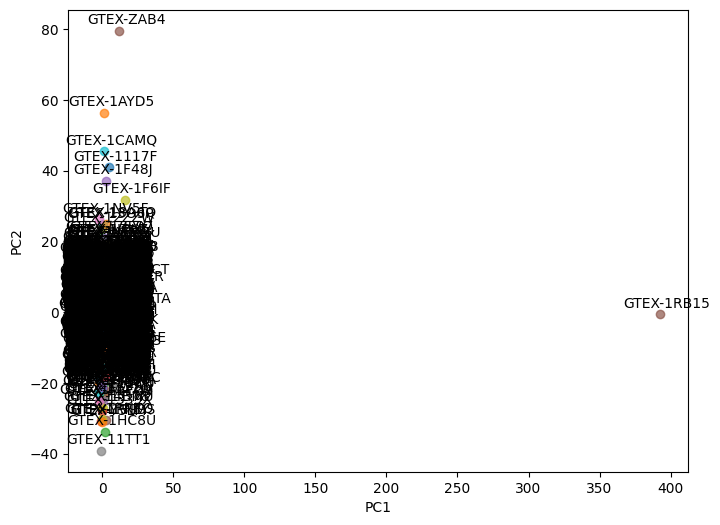

In [19]:
# Perform principle component analysis to visualize robust gene selection outcomes
principalComponents = run_PCA(df=robust_normalized_counts_df, standardize=True, n_components=2, 
                              metadata = None,
                              plot_title=None,
                              save_dir = None)

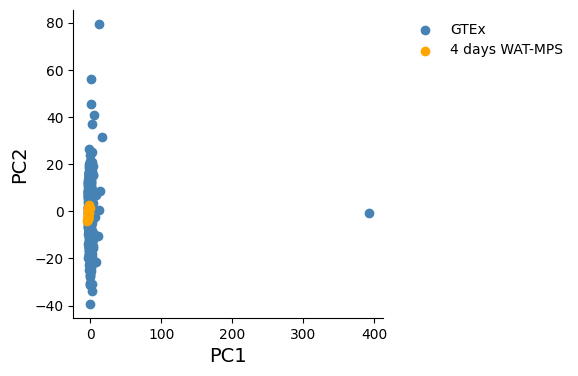

In [20]:
# Plot PCA with dataset origin as color

# Plot PCA plot and color the dots by group
groups = create_groups(metadata = merged_metadata, 
                       col = 'batch', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'GTEx':'steelblue', '4 days WAT-MPS': 'orange'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

#plt.tight_layout()
plt.savefig(classification_savedir + 'Norm_counts/2_PCA_after_MOR_find_robust_genes.pdf', bbox_inches='tight')
plt.show()

In [21]:
# Extract the datasets, save all three dfs as excel
co_normalized_counts_savedir = classification_savedir + 'Norm_counts/'

GTEx_sample_list = GTEx_df.columns.tolist()
robust_GTEx_normalized_counts_df = robust_normalized_counts_df[GTEx_sample_list]
# robust_GTEx_normalized_counts_df.to_excel(co_normalized_counts_savedir + 'GTEx_conormalized_counts.xlsx')

serum_4day_sample_list = serum_4day_df.columns.tolist()
robust_serum_4day_normalized_counts_df = robust_normalized_counts_df[serum_4day_sample_list]
# robust_serum_4day_normalized_counts_df.to_excel(co_normalized_counts_savedir + 'serum_4day_conormalized_counts.xlsx')

In [22]:
robust_GTEx_normalized_counts_df

,GTEX-1117F,GTEX-111CU,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-117YW,GTEX-117YX,GTEX-1192X,GTEX-11DXX,...,GTEX-ZVZP,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYFG,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZZ64,GTEX-ZZPU
RNA5SP292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SNORD115-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SNORD115-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MIR3116-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MLECP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDFI,1200.497256,2823.634733,756.372447,5961.830191,1784.708000,451.104546,494.894683,1452.439086,2472.066675,1901.806644,...,409.1266,1012.313554,1332.229135,8665.901683,5224.357147,3608.777483,846.162993,959.313468,1579.792587,2699.440679
NMUR2,0.000000,0.000000,1.275502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,2.229766,2.214845,1.907948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LINC00431,3.188572,5.026497,1.275502,1.147830,24.314823,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,25.887800,0.000000,0.000000,0.000000,16.806304,39.631428
RNU4-80P,3.188572,0.000000,0.000000,0.000000,0.000000,1.174751,0.000000,1.072702,3.150467,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.938320,1.087613,2.056406,0.000000,0.900714


In [23]:
# Read in metadata file
metadata_savedir = '/Volumes/RNA_s2/20240324_sexual_dimorphic_index/Downloads/bulkRNAseq/metadata/'

metadata = pd.read_excel(metadata_savedir + 'GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.xlsx')
metadata = NameRows_Gene(metadata)

# trim metadata to match samples in df
VAT_sample_list = robust_GTEx_normalized_counts_df.columns.unique().tolist()
VAT_sample_list

# Find the subjects in metadata that don't have SAT samples; then drop them
drop_indexes = metadata.index[~metadata.index.isin(VAT_sample_list)].tolist()
metadata_VAT = metadata.drop(drop_indexes, axis=0)
    
metadata_VAT

# Create a new column 'sex' based on the values in column 'SEX'
metadata_VAT['sex'] = metadata_VAT['SEX'].apply(lambda x: 'male' if x == 1 else 'female')

metadata_VAT

,SEX,AGE,DTHHRDY,sex
SUBJID,,,,
GTEX-1117F,2,60-69,4.0,female
GTEX-111CU,1,50-59,0.0,male
GTEX-111YS,1,60-69,0.0,male
GTEX-1122O,2,60-69,0.0,female
GTEX-1128S,2,60-69,2.0,female
...,...,...,...,...
GTEX-ZYT6,1,30-39,1.0,male
GTEX-ZYVF,2,50-59,0.0,female
GTEX-ZYW4,1,60-69,3.0,male


In [25]:
# Split the SAT_relative_abundance_df and metadata_SAT by sex
def split_by_sex(df, metadata, split_by, condition_to_keep):
    samples_to_keep = metadata.index[metadata[split_by] == condition_to_keep]
    selected_df = df[samples_to_keep]
    selected_metadata = metadata.T[samples_to_keep].T
    
    return selected_df, selected_metadata

male_norm_counts_df, male_metadata_VAT = split_by_sex(df = robust_GTEx_normalized_counts_df,
                                                      metadata=metadata_VAT,
                                                      split_by='sex',
                                                      condition_to_keep='male')

female_normalized_counts_df, female_metadata_VAT = split_by_sex(df = robust_GTEx_normalized_counts_df,
                                                                metadata=metadata_VAT,
                                                                split_by='sex',
                                                                condition_to_keep='female')

# Male Model

In [26]:
male_metadata_VAT

,SEX,AGE,DTHHRDY,sex
SUBJID,,,,
GTEX-111CU,1,50-59,0.0,male
GTEX-111YS,1,60-69,0.0,male
GTEX-117YW,1,50-59,3.0,male
GTEX-117YX,1,50-59,0.0,male
GTEX-1192X,1,50-59,4.0,male
...,...,...,...,...
GTEX-ZXG5,1,60-69,3.0,male
GTEX-ZYFC,1,50-59,2.0,male
GTEX-ZYT6,1,30-39,1.0,male


# Run PCA to visualize the data first

12355 features are kept are NaN Removal
Running PCA with n_componenets=2


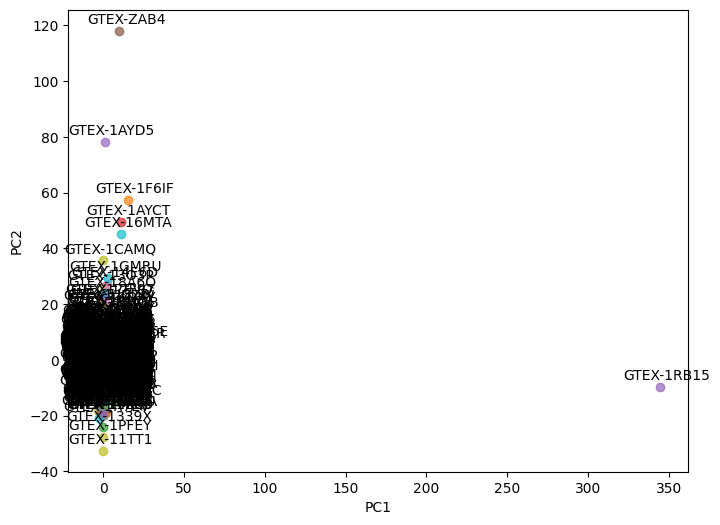

In [27]:
# Plot PCA of male_norm_counts_df to gain priliminary knowledge of the male sample
# Run pca
principalComponents = run_PCA(df=male_norm_counts_df, standardize=True, n_components=2, 
                              metadata = male_metadata_VAT,
                              plot_title=None,
                              save_dir = None)

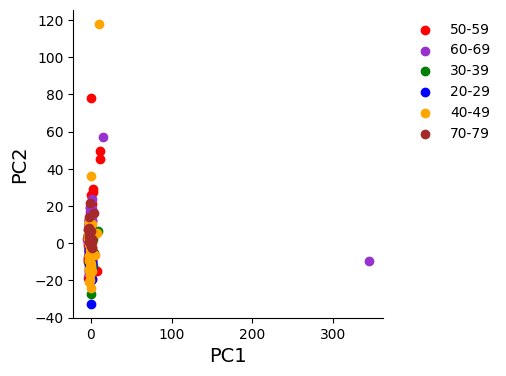

In [28]:
# Plot PCA plot and color the dots by group
groups = create_groups(metadata = male_metadata_VAT, 
                       col = 'AGE', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

#plt.tight_layout()
plt.savefig(classification_savedir + 'Male/Data_filtration_figures/0_PCA_normalized_GTEx_before_filtering.pdf', bbox_inches='tight')
plt.show()

# Perform data filtering

In [29]:
# Remove rows with null values
male_norm_counts_df.dropna(inplace=True)

# Remove duplicate rows
male_norm_counts_df.drop_duplicates(inplace=True)

# Remove genes with less than 100 total counts
male_norm_counts_df = male_norm_counts_df[male_norm_counts_df.iloc[:, :-1].sum(axis=1) >= 100]

# Remove mitochondrial genes
male_norm_counts_df = male_norm_counts_df[~male_norm_counts_df.index.str.startswith('MT-')]

/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/2218309582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_norm_counts_df.dropna(inplace=True)
/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/2218309582.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_norm_counts_df.drop_duplicates(inplace=True)


In [30]:
male_norm_counts_df

,GTEX-111CU,GTEX-111YS,GTEX-117YW,GTEX-117YX,GTEX-1192X,GTEX-11DXY,GTEX-11DXZ,GTEX-11DYG,GTEX-11EQ9,GTEX-11GS4,...,GTEX-ZUA1,GTEX-ZV7C,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVZP,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYT6,GTEX-ZYW4,GTEX-ZZ64
LCE3A,1.256624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.431349,1.005113,...,2.554810,12.239665,0.000000,4.113194,0.000000,0.000000,1.907948,0.000000,0.000000,3.601351
SPDYE21P,2.513249,2.551003,4.341181,0.000000,1.050156,5.402512,3.104478,0.948289,4.862698,4.020451,...,4.258016,4.895866,4.745546,5.141492,0.000000,3.322267,3.815897,0.000000,2.056406,2.400901
RRP12,2816.094987,3911.963400,1586.701811,2580.922039,1197.177574,1431.665670,782.328449,1095.273852,2176.057265,876.458326,...,752.817207,4916.673304,1184.488374,2807.254899,4481.033295,763.014027,746.007829,665.268652,1206.082206,3295.236057
PCDHA12,7.539746,8.928511,29.302975,40.762692,0.000000,18.008373,3.104478,53.104187,4.862698,16.081804,...,8.516032,2.447933,19.931295,3.084895,1.290620,4.429690,0.953974,11.259836,66.833200,9.603602
ERVH-1,0.000000,0.000000,1.085295,0.000000,0.000000,8.103768,0.000000,0.000000,0.000000,0.000000,...,1.703206,1.223966,0.000000,0.000000,0.000000,0.000000,0.953974,1.876639,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDFI,2823.634733,756.372447,494.894683,1452.439086,2472.066675,1413.657297,1830.607179,1030.790197,11968.314956,2105.711230,...,1916.958748,1751.496016,1112.356069,791.789843,409.126600,1332.229135,8665.901683,3608.777483,959.313468,1579.792587
NMUR2,0.000000,1.275502,0.000000,0.000000,0.000000,1.800837,2.069652,1.896578,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.214845,1.907948,0.000000,0.000000,0.000000
LINC00431,5.026497,1.275502,0.000000,0.000000,0.000000,12.605861,0.000000,0.000000,1.215674,0.000000,...,55.354206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.806304
RNU4-80P,0.000000,0.000000,0.000000,1.072702,3.150467,0.900419,0.000000,0.948289,0.000000,1.005113,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.938320,2.056406,0.000000


2214 features are kept are NaN Removal
Running PCA with n_componenets=2


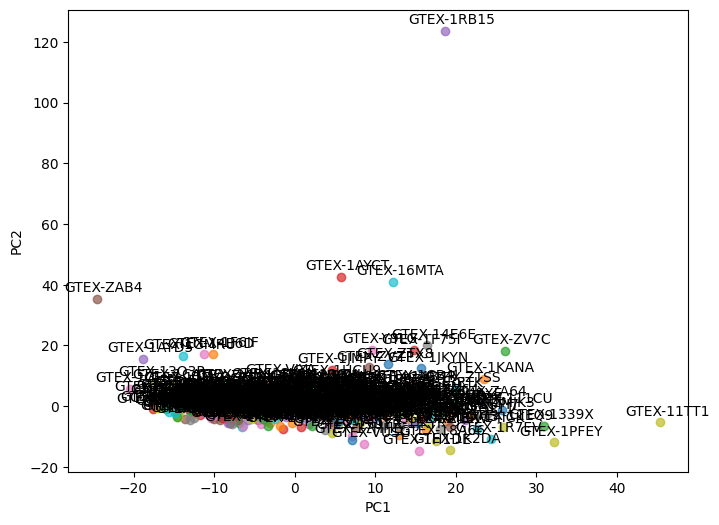

In [31]:
# Run pca
principalComponents = run_PCA(df=male_norm_counts_df, standardize=True, n_components=2, 
                              metadata = male_metadata_VAT,
                              plot_title=None,
                              save_dir = None)

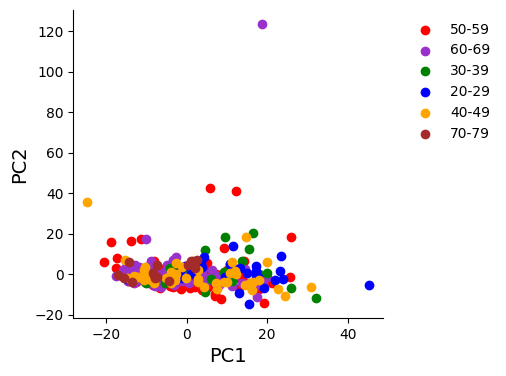

In [32]:
# Plot PCA plot and color the dots by group
groups = create_groups(metadata = male_metadata_VAT, 
                       col = 'AGE', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

#plt.tight_layout()
plt.savefig(classification_savedir + 'Male/Data_filtration_figures/1_PCA_normalized_GTEx_after_primary_filtering.pdf', bbox_inches='tight')
plt.show()

# Log transformation
we will apply log1p to normalized counts


In [33]:
# Logarithmize the data
male_norm_counts_df_log1p = male_norm_counts_df.apply(np.log1p)

2214 features are kept are NaN Removal
Running PCA with n_componenets=2


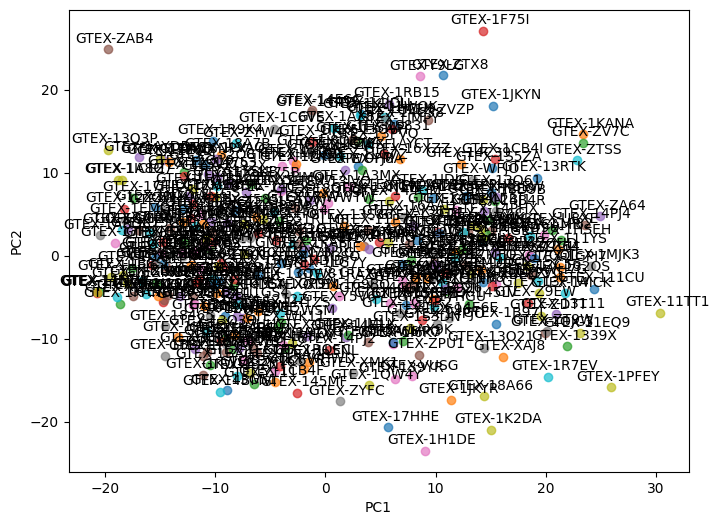

In [34]:
# Run pca on log transformed data
principalComponents = run_PCA(df=male_norm_counts_df_log1p, standardize=True, n_components=2, 
                              metadata = male_metadata_VAT,
                              plot_title=None,
                              save_dir = None)

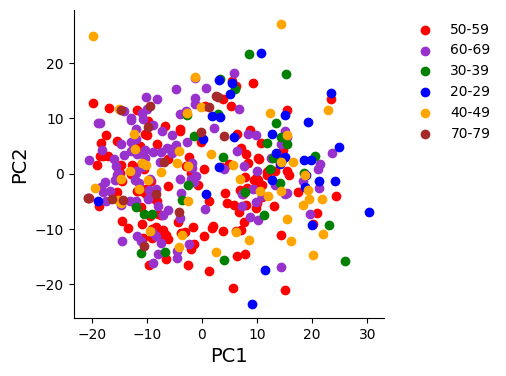

In [35]:
# Plot PCA plot and color the dots by group
groups = create_groups(metadata = male_metadata_VAT, 
                       col = 'AGE', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

#plt.tight_layout()
plt.savefig(classification_savedir + 'Male/Data_filtration_figures/2_PCA_normalized_GTEx_log_transformed.pdf', bbox_inches='tight')
plt.show()

# Feature selection
To reduce the dimensionality of the dataset and only include the most informative genes (highly variable genes)

In [36]:
def calculate_gene_VMR(df):
    mean_per_feature = df.mean(axis=1)
    variance_per_feature = df.var(axis=1)
    return variance_per_feature / mean_per_feature

def calculate_gene_mean(df):
    mean_per_feature = df.mean(axis=1)
    return mean_per_feature

In [37]:
male_gene_stats_df = pd.DataFrame()
male_gene_stats_df['Mean Gene Expression'] = calculate_gene_mean(male_norm_counts_df_log1p)
male_gene_stats_df['Variance Mean Ratio (VMR)'] = calculate_gene_VMR(male_norm_counts_df_log1p)

male_gene_stats_df

,Mean Gene Expression,Variance Mean Ratio (VMR)
LCE3A,0.461897,0.881590
SPDYE21P,1.195259,0.338503
RRP12,7.422074,0.056744
PCDHA12,2.548154,0.465281
ERVH-1,0.235090,0.909570
...,...,...
MDFI,7.341009,0.066241
NMUR2,0.309310,1.055201
LINC00431,0.939647,1.853139
RNU4-80P,0.246064,0.753881


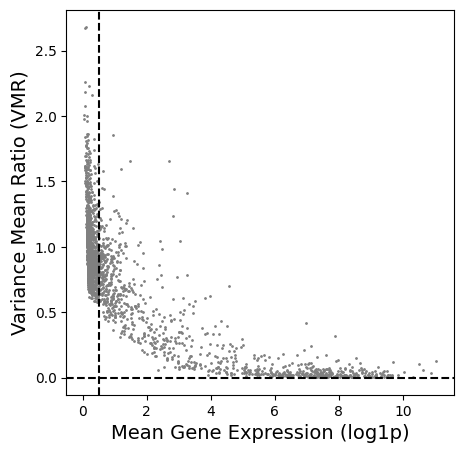

In [38]:
# Visualize gene variables
plt.figure(figsize=[5,5])
# Plot the scatter plot
plt.scatter(male_gene_stats_df['Mean Gene Expression'], male_gene_stats_df['Variance Mean Ratio (VMR)'], color='gray', s=1)

# Plot threshold
plt.axvline(x=0.5, color='black', linestyle='--') # mean threshold
plt.axhline(y=0, color='black', linestyle='--') # VMR threshold

# Add labels and title
plt.xlabel('Mean Gene Expression (log1p)', fontsize=14)
plt.ylabel('Variance Mean Ratio (VMR)', fontsize=14)

# Show plot
plt.grid(False)
plt.savefig(classification_savedir + 'Male/Data_filtration_figures/3_scatter_plot_VMR_Mean_filter.pdf', bbox_inches='tight')
plt.show()

In [39]:
# Select highly variable genes with threshold: mean_expression_threshold=0.1, VMR_threshold=0.1
def highly_variable_gene_selection(counts_df, stats_df, mean_expression_threshold, VMR_threshold):
    filtered_stats_df = stats_df[(stats_df['Mean Gene Expression'] >= mean_expression_threshold) & (stats_df['Variance Mean Ratio (VMR)'] > VMR_threshold)]
    genes_to_keep = filtered_stats_df.index.tolist()

    filtered_counts_df = counts_df.T[genes_to_keep].T
    return filtered_counts_df
    
male_norm_counts_df_log1p_filtered = highly_variable_gene_selection(counts_df=male_norm_counts_df_log1p,
                                                                    stats_df=male_gene_stats_df,
                                                                    mean_expression_threshold=0.5,
                                                                    VMR_threshold=0)

male_norm_counts_df_log1p_filtered

,GTEX-111CU,GTEX-111YS,GTEX-117YW,GTEX-117YX,GTEX-1192X,GTEX-11DXY,GTEX-11DXZ,GTEX-11DYG,GTEX-11EQ9,GTEX-11GS4,...,GTEX-ZUA1,GTEX-ZV7C,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVZP,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYT6,GTEX-ZYW4,GTEX-ZZ64
SPDYE21P,1.256541,1.267230,1.675447,0.000000,0.717916,1.856690,1.412079,0.666952,1.768610,1.613520,...,1.659754,1.774251,1.748425,1.815068,0.000000,1.463780,1.571922,0.000000,1.117240,1.224040
RRP12,7.943461,8.272050,7.370043,7.856289,7.088557,7.267292,6.663552,6.999672,7.685729,6.777029,...,6.625150,8.500591,7.077910,7.940319,8.407832,6.638586,6.616076,6.501693,7.095961,8.100537
PCDHA12,2.144731,2.295411,3.411246,3.732003,0.000000,2.944880,1.412079,3.990912,1.768610,2.838014,...,2.252978,1.237775,3.041245,1.407296,0.828823,1.691882,0.669865,2.506329,4.217052,2.361194
BTG3,7.317502,7.772093,7.392350,7.814722,7.629104,6.792921,6.800386,7.466626,7.797612,7.526415,...,7.167260,7.959925,7.888016,7.220819,7.418121,7.673974,7.368086,7.177749,8.145415,7.663031
GTF2IP7,0.000000,0.000000,1.153918,0.000000,0.717916,1.988276,2.109459,1.063530,1.232953,0.000000,...,0.616052,0.799292,0.000000,1.117302,0.828823,1.877495,0.000000,0.661821,1.117240,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HSPB8,9.225303,8.275630,8.596426,8.718741,7.665199,8.035161,8.044914,8.200927,8.644818,8.113721,...,8.109167,8.781103,7.956485,8.599960,8.523284,7.970635,8.046664,8.046482,8.533535,9.104132
SLC35G6,0.000000,2.157907,0.000000,1.665971,1.423221,1.029918,0.710410,0.000000,0.795557,0.695700,...,0.616052,1.237775,1.064096,0.000000,0.828823,2.578825,1.067448,1.558835,0.707150,1.224040
RN7SKP97,2.510381,2.866848,2.715280,1.439387,1.988002,2.389185,2.429064,1.900574,1.536227,1.796011,...,1.659754,3.024488,1.567873,2.327735,3.187640,0.745466,1.067448,1.338930,2.221985,2.653591
MDFI,7.946134,6.629855,6.206364,7.281688,7.813214,7.254643,7.512949,6.939051,9.390102,7.652883,...,7.559017,7.468796,7.015134,6.675558,6.016466,7.195359,9.067267,8.191401,6.867260,7.365682


919 features are kept are NaN Removal
Running PCA with n_componenets=2


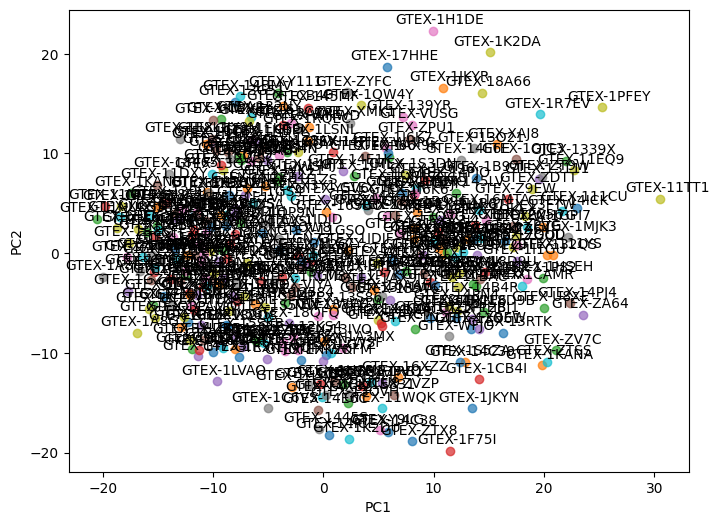

In [40]:
# Run pca on feature selection outcome
principalComponents = run_PCA(df=male_norm_counts_df_log1p_filtered, standardize=True, n_components=2, 
                              metadata = male_metadata_VAT,
                              plot_title=None,
                              save_dir = None)

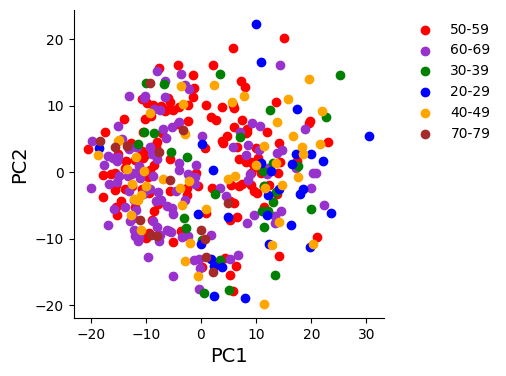

In [41]:
# Plot PCA plot and color the dots by group
groups = create_groups(metadata = male_metadata_VAT, 
                       col = 'AGE', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

plt.savefig(classification_savedir + 'Male/Data_filtration_figures/3_PCA_normalized_GTEx_after_feature_selection.pdf', bbox_inches='tight')
plt.show()

# Dimension reduction
To reduce the dimensionality of the dataset, we employed RDA (Regularized Discriminant Analysis). Optional feature selection (highly variable gene selection) step with VMR and Mean expression can be performed before this if needed.

Shrinkage parameter of run_RDA function can be tuned to achieve best outcome.

919 features are kept after NaN Removal
Running RDA with n_components=2 and shrinkage=0.3


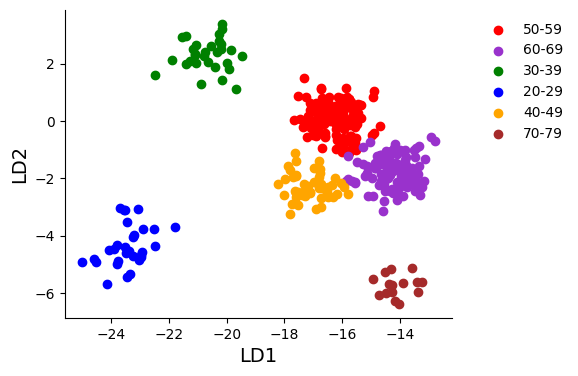

In [42]:
# run RDA 
X_r2, rda = run_RDA(df=male_norm_counts_df_log1p_filtered, standardize=False, n_components=2, 
                    metadata = male_metadata_VAT, design_factor='AGE', shrinkage=0.3,
                    plot_title=None,
                    save_dir = None)

# Plot RDA plot and color the dots by group
groups = create_groups(metadata = male_metadata_VAT, 
                       col = 'AGE', 
                       Components=X_r2)
    
import matplotlib.patches as patches
from scipy.stats import chi2

plt.figure(figsize=(5, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('LD1', fontsize=14)
plt.ylabel('LD2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

plt.savefig(classification_savedir + 'Male/Data_filtration_figures/3_RDA_normalized_GTEx_after_all_filtering.pdf', bbox_inches='tight')
plt.show()

In [43]:
# Save the LDA model
import joblib

rda_joblib_file = classification_savedir + 'Male/Models/rda_model.joblib'
joblib.dump(rda, rda_joblib_file)

['/Volumes/RNA_s2/Figure_2_outs/5_alternative_Final_VAT_Classification_model_with_GTEx/Male/Models/rda_model.joblib']

In [44]:
# save GTEx LDA transformed results
np.save(classification_savedir + 'Male/Models/GTEx_RDA_transformed_array_X_r2.npy', X_r2)

# Classifier training
GTEx data contains age groups include: 
1. 20-29 group (shown in blue)
2. 30-39 group (shown in orange)
3. 40-49 group (shown in green)
4. 50-59 group (shown in red)
5. 60-69 group (shown in darkorchid)
5. 70-79 group (shown in brown)

Therefore, we will first train a classification model that classfies the data points into 6 groups using RDA transformed data.

For model training and application, we will follow the following steps:
1. Train a classification model on the RDA-transformed training data (Random forest is used here).
2. Transform the new data points using the same RDA model.
3. Use the trained random forest classification model to predict the class labels for the RDA-transformed new data points.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Determine learning samples
X = X_r2 # The LDA model that we trained previously when we visualize male_norm_counts_df_log1p_filtered
y = male_metadata_VAT['AGE']

# Use only 5 classes instead of 6 (merge '50-59' and '60-69' classes)
condition_mapping = {
    '20-29': '20-29',
    '30-39': '30-39',
    '40-49': '40-49',
    '50-59': '50-59',
    '60-69': '60-69',
    '70-79': '70-79'
}

y_condition = y.map(condition_mapping)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_condition, test_size=0.3, random_state=42)

X_train

array([[-2.28931813e+01, -3.77379268e+00],
       [-1.60002560e+01,  3.89989394e-01],
       [-1.67201652e+01, -2.20246761e+00],
       [-1.67309430e+01,  3.94679333e-02],
       [-1.43850979e+01, -1.20191748e+00],
       [-2.38037858e+01, -5.00618210e+00],
       [-2.24684057e+01,  1.60855469e+00],
       [-1.70310956e+01, -1.07909464e-02],
       [-1.68227609e+01,  2.11387416e-01],
       [-1.44393112e+01, -1.70724782e+00],
       [-1.45594401e+01, -2.28274751e+00],
       [-1.59663301e+01,  3.48716449e-01],
       [-1.60491963e+01,  2.75546107e-02],
       [-1.42537023e+01, -1.03122243e+00],
       [-1.77949529e+01, -3.23883840e+00],
       [-1.65393230e+01, -2.46973923e+00],
       [-2.06590674e+01,  2.06554846e+00],
       [-1.67914781e+01,  4.13781403e-01],
       [-1.67309350e+01,  1.11622459e+00],
       [-1.34817789e+01, -2.24009481e+00],
       [-1.60696469e+01,  2.21491226e-01],
       [-1.62089588e+01, -9.91318911e-01],
       [-1.42361089e+01, -2.52580027e+00],
       [-1.

In [47]:
y_train

SUBJID
GTEX-1H1DE    20-29
GTEX-11WQK    50-59
GTEX-ZPU1     40-49
GTEX-144GN    50-59
GTEX-1C6VS    60-69
              ...  
GTEX-13S86    40-49
GTEX-14PJN    30-39
GTEX-1N2DW    50-59
GTEX-ZDTT     60-69
GTEX-14PHX    50-59
Name: AGE, Length: 259, dtype: object

In [48]:
# Training with random forest classfication model 
rf_accuracy, rf = train_and_evaluate_classifier(X_train, y_train, X_test, y_test, 
                                              algorithm='random_forest', n_estimators=100, max_depth=10)


Accuracy of the classifier (random_forest): 0.9732142857142857


In [49]:
# Save the RF model
RF_joblib_file = classification_savedir + 'Male/Models/rf_classification_model.joblib'
joblib.dump(rf, RF_joblib_file)


['/Volumes/RNA_s2/Figure_2_outs/5_alternative_Final_VAT_Classification_model_with_GTEx/Male/Models/rf_classification_model.joblib']

In [50]:
# Save prediction accuracy
accuracy_df = pd.DataFrame()
accuracy_df['random forest'] = [rf_accuracy]

accuracy_df.to_excel(classification_savedir + 'Male/Models/Model_cross_validation_accuracies.xlsx')

In [51]:
# Predict on the entire dataset
prediction_results_df = pd.DataFrame(index=male_norm_counts_df_log1p.columns.tolist())

y_all_pred_rf = rf.predict(X)
prediction_results_df['rf_predicted_age'] = y_all_pred_rf

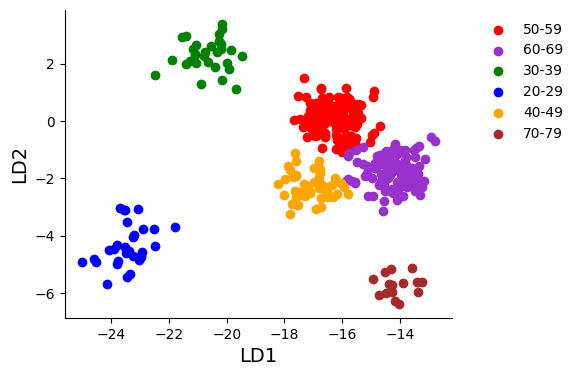

In [52]:
# Plot RDA plot and color the dots by group
groups = create_groups(metadata = prediction_results_df, 
                       col = 'rf_predicted_age', 
                       Components=X_r2)


plt.figure(figsize=(5, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('LD1', fontsize=14)
plt.ylabel('LD2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white') 

plt.savefig(classification_savedir + 'Male/Classifier_output_figures/1_RF_GTEx_male_all_datapoint_classification_prediction_results.pdf', bbox_inches='tight')
plt.show()

# Female Model

In [53]:
female_normalized_counts_df

,GTEX-1117F,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-11DXX,GTEX-11EM3,GTEX-11GSP,GTEX-11I78,GTEX-11P81,GTEX-11VI4,...,GTEX-ZPCL,GTEX-ZPIC,GTEX-ZQG8,GTEX-ZTPG,GTEX-ZV6S,GTEX-ZVT2,GTEX-ZXES,GTEX-ZYFG,GTEX-ZYVF,GTEX-ZZPU
RNA5SP292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SNORD115-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SNORD115-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MIR3116-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MLECP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDFI,1200.497256,5961.830191,1784.708000,451.104546,1901.806644,1440.610134,2635.823839,4725.188350,4422.080067,636.89027,...,1095.164657,3613.023195,2104.214778,1669.679509,3146.196702,841.553212,1012.313554,5224.357147,846.162993,2699.440679
NMUR2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.138310,0.000000,0.000000,1.14138,...,1.173810,0.000000,2.410326,0.838614,0.000000,2.750174,2.229766,0.000000,0.000000,0.000000
LINC00431,3.188572,1.147830,24.314823,0.000000,0.000000,34.574643,12.117092,30.320767,1.552969,0.00000,...,28.171438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.887800,0.000000,39.631428
RNU4-80P,3.188572,0.000000,0.000000,1.174751,0.000000,0.000000,1.425540,0.000000,0.000000,0.00000,...,2.347620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.087613,0.900714


# Run PCA to visualize the data first

12355 features are kept are NaN Removal
Running PCA with n_componenets=2


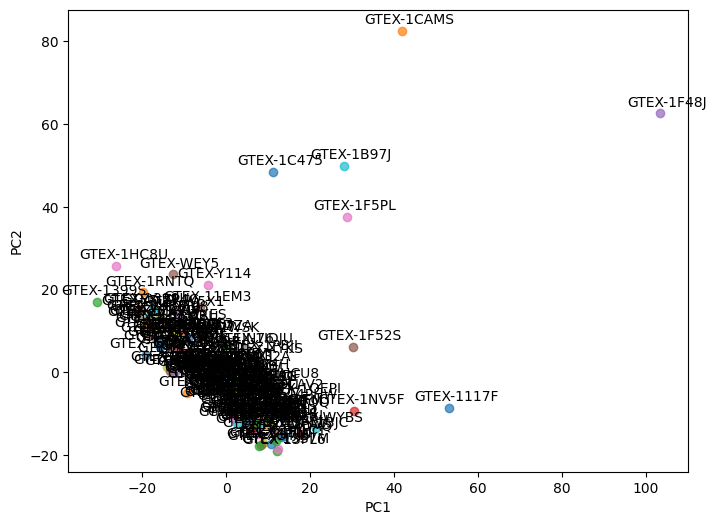

In [54]:
# Plot PCA of male_norm_counts_df to gain priliminary knowledge of the male sample
# Run pca
principalComponents = run_PCA(df=female_normalized_counts_df, standardize=True, n_components=2, 
                              metadata = female_metadata_VAT,
                              plot_title=None,
                              save_dir = None)

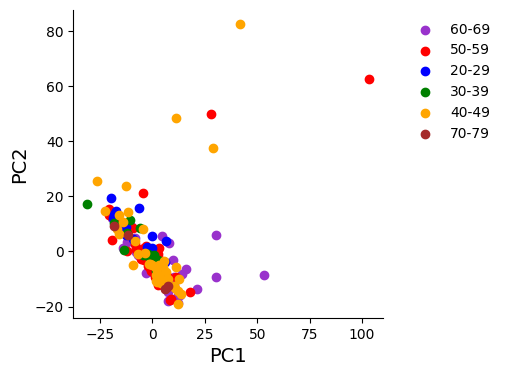

In [55]:
# Plot PCA plot and color the dots by group
groups = create_groups(metadata = female_metadata_VAT, 
                       col = 'AGE', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

#plt.tight_layout()
plt.savefig(classification_savedir + 'Female/Data_filtration_figures/0_PCA_normalized_GTEx_before_filtering.pdf', bbox_inches='tight')
plt.show()

# Perform data filtering

In [56]:
# Remove rows with null values
female_normalized_counts_df.dropna(inplace=True)

# Remove duplicate rows
female_normalized_counts_df.drop_duplicates(inplace=True)

# Remove genes with less than 50 total counts (total count threshold determined by sample size)
female_normalized_counts_df = female_normalized_counts_df[female_normalized_counts_df.iloc[:, :-1].sum(axis=1) >= 50]

# Remove mitochondrial genes
female_normalized_counts_df = female_normalized_counts_df[~female_normalized_counts_df.index.str.startswith('MT-')]

/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/613646496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_normalized_counts_df.dropna(inplace=True)
/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/613646496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_normalized_counts_df.drop_duplicates(inplace=True)


In [57]:
female_normalized_counts_df

,GTEX-1117F,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-11DXX,GTEX-11EM3,GTEX-11GSP,GTEX-11I78,GTEX-11P81,GTEX-11VI4,...,GTEX-ZPCL,GTEX-ZPIC,GTEX-ZQG8,GTEX-ZTPG,GTEX-ZV6S,GTEX-ZVT2,GTEX-ZXES,GTEX-ZYFG,GTEX-ZYVF,GTEX-ZZPU
LCE3A,0.000000,0.000000,0.000000,0.000000,0.000000,3.457464,0.000000,2.425661,0.776485,2.282761,...,1.173810,1.863824,1.205163,1.677227,1.235256,0.000000,0.000000,0.000000,2.175226,0.900714
SPDYE21P,1.594286,3.443491,1.945186,2.349503,3.294122,0.000000,1.425540,8.489815,4.658908,0.000000,...,0.000000,0.000000,3.615489,0.000000,1.235256,2.750174,2.229766,0.000000,2.175226,2.702143
RRP12,1938.651612,1502.509765,2503.454165,1199.421203,1886.434073,9928.685041,817.547307,4603.905281,1201.998234,1213.287378,...,1281.800435,994.350206,1464.273170,1455.833062,2778.090453,1016.189255,3746.006104,802.521795,4182.959990,2265.296399
PCDHA12,12.754287,2.295660,4.862965,19.970774,5.490204,0.000000,15.680942,9.702645,3.882423,15.979326,...,1.173810,74.552968,16.872283,3.354454,3.705768,5.500348,12.263710,14.935269,2.175226,24.319285
CARD17,0.000000,0.000000,0.000000,4.699006,0.000000,0.000000,0.000000,6.064153,2.329454,1.141380,...,0.000000,0.000000,1.205163,6.708908,0.000000,0.000000,2.229766,1.991369,2.175226,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDFI,1200.497256,5961.830191,1784.708000,451.104546,1901.806644,1440.610134,2635.823839,4725.188350,4422.080067,636.890270,...,1095.164657,3613.023195,2104.214778,1669.679509,3146.196702,841.553212,1012.313554,5224.357147,846.162993,2699.440679
NMUR2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.138310,0.000000,0.000000,1.141380,...,1.173810,0.000000,2.410326,0.838614,0.000000,2.750174,2.229766,0.000000,0.000000,0.000000
LINC00431,3.188572,1.147830,24.314823,0.000000,0.000000,34.574643,12.117092,30.320767,1.552969,0.000000,...,28.171438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.887800,0.000000,39.631428
RNU4-80P,3.188572,0.000000,0.000000,1.174751,0.000000,0.000000,1.425540,0.000000,0.000000,0.000000,...,2.347620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.087613,0.900714


2000 features are kept are NaN Removal
Running PCA with n_componenets=2


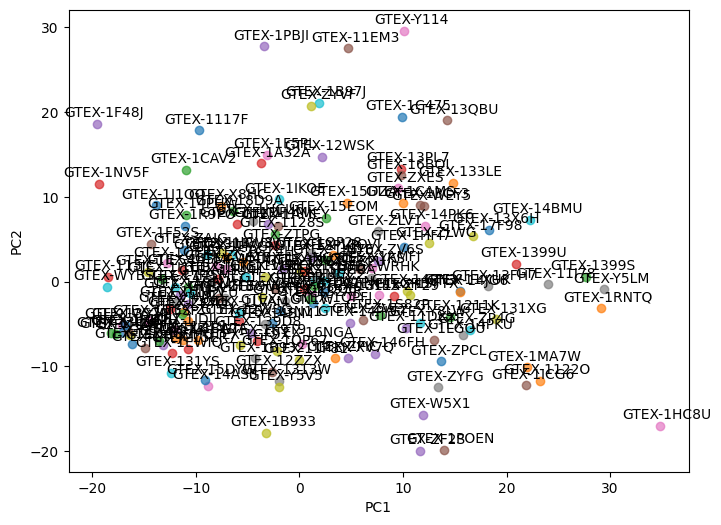

In [58]:
# Run pca
principalComponents = run_PCA(df=female_normalized_counts_df, standardize=True, n_components=2, 
                              metadata = female_metadata_VAT,
                              plot_title=None,
                              save_dir = None)

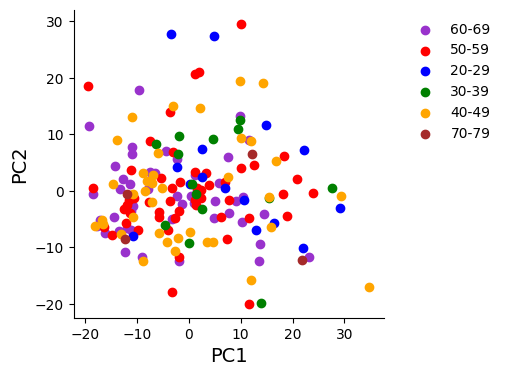

In [59]:
# Plot PCA plot and color the dots by group
groups = create_groups(metadata = female_metadata_VAT, 
                       col = 'AGE', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

#plt.tight_layout()
plt.savefig(classification_savedir + 'Female/Data_filtration_figures/1_PCA_normalized_GTEx_after_primary_filtering.pdf', bbox_inches='tight')
plt.show()

# Log Transformation
we will apply log1p


In [60]:
# Logarithmize the data
female_norm_counts_df_log1p = female_normalized_counts_df.apply(np.log1p)


2000 features are kept are NaN Removal
Running PCA with n_componenets=2


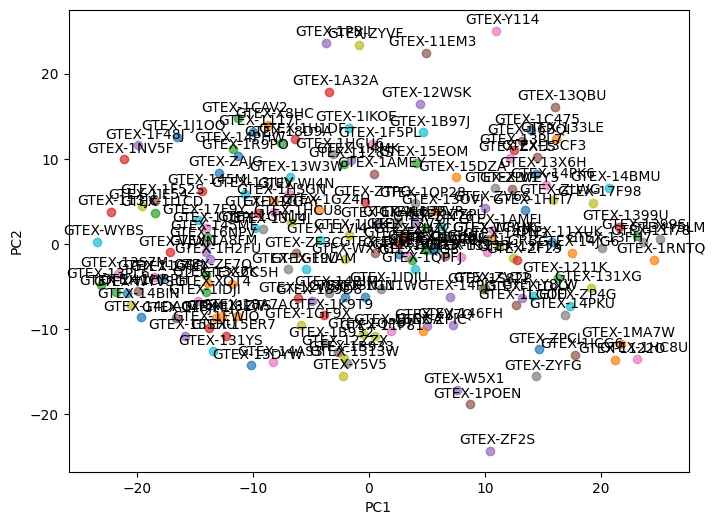

In [61]:
# Run pca on log transformed data
principalComponents = run_PCA(df=female_norm_counts_df_log1p, standardize=True, n_components=2, 
                              metadata = female_metadata_VAT,
                              plot_title=None,
                              save_dir = None)

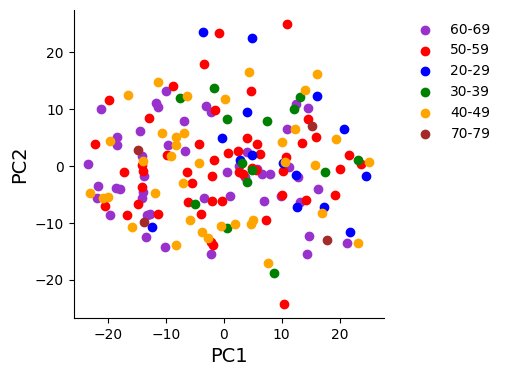

In [62]:
# Plot PCA plot and color the dots by group
groups = create_groups(metadata = female_metadata_VAT, 
                       col = 'AGE', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

#plt.tight_layout()
plt.savefig(classification_savedir + 'Female/Data_filtration_figures/2_PCA_normalized_GTEx_after_log_transformation.pdf', bbox_inches='tight')
plt.show()

# Feature selection
To reduce the dimensionality of the dataset and only include the most informative genes (highly variable genes)

In [63]:
def calculate_gene_VMR(df):
    mean_per_feature = df.mean(axis=1)
    variance_per_feature = df.var(axis=1)
    return variance_per_feature / mean_per_feature

def calculate_gene_mean(df):
    mean_per_feature = df.mean(axis=1)
    return mean_per_feature

In [64]:
female_gene_stats_df = pd.DataFrame()
female_gene_stats_df['Mean Gene Expression'] = calculate_gene_mean(female_norm_counts_df_log1p)
female_gene_stats_df['Variance Mean Ratio (VMR)'] = calculate_gene_VMR(female_norm_counts_df_log1p)

female_gene_stats_df

,Mean Gene Expression,Variance Mean Ratio (VMR)
LCE3A,0.396168,0.850927
SPDYE21P,1.166313,0.369784
RRP12,7.520355,0.056512
PCDHA12,2.549687,0.459949
CARD17,0.480608,0.926375
...,...,...
MDFI,7.373438,0.072595
NMUR2,0.309866,0.985596
LINC00431,0.869896,2.097748
RNU4-80P,0.203832,0.938879


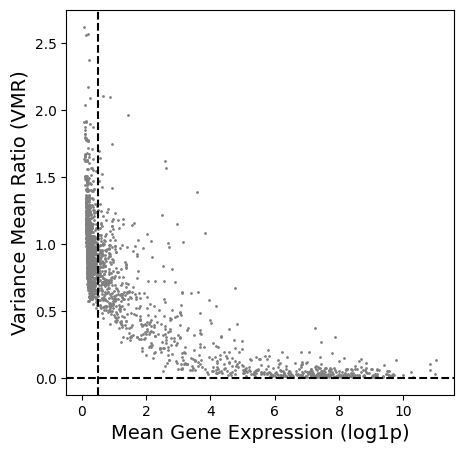

In [65]:
# Visualize gene variables
plt.figure(figsize=[5,5])
# Plot the scatter plot
plt.scatter(female_gene_stats_df['Mean Gene Expression'], female_gene_stats_df['Variance Mean Ratio (VMR)'], color='gray', s=1)

# Plot threshold
plt.axvline(x=0.5, color='black', linestyle='--') # mean threshold
plt.axhline(y=0, color='black', linestyle='--') # VMR threshold

# Add labels and title
plt.xlabel('Mean Gene Expression (log1p)', fontsize=14)
plt.ylabel('Variance Mean Ratio (VMR)', fontsize=14)

# Show plot
plt.grid(False)
plt.savefig(classification_savedir + 'Female/Data_filtration_figures/3_scatter_plot_VMR_Mean_filter.pdf', bbox_inches='tight')
plt.show()

In [66]:
# Select highly variable genes with threshold: mean_expression_threshold=0, VMR_threshold=0.1
def highly_variable_gene_selection(counts_df, stats_df, mean_expression_threshold, VMR_threshold):
    filtered_stats_df = stats_df[(stats_df['Mean Gene Expression'] >= mean_expression_threshold) & (stats_df['Variance Mean Ratio (VMR)'] > VMR_threshold)]
    genes_to_keep = filtered_stats_df.index.tolist()

    filtered_counts_df = counts_df.T[genes_to_keep].T
    return filtered_counts_df
    
female_norm_counts_df_log1p_filtered = highly_variable_gene_selection(counts_df=female_norm_counts_df_log1p,
                                                                      stats_df=female_gene_stats_df,
                                                                      mean_expression_threshold=0.5,
                                                                      VMR_threshold=0)

female_norm_counts_df_log1p_filtered

,GTEX-1117F,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-11DXX,GTEX-11EM3,GTEX-11GSP,GTEX-11I78,GTEX-11P81,GTEX-11VI4,...,GTEX-ZPCL,GTEX-ZPIC,GTEX-ZQG8,GTEX-ZTPG,GTEX-ZV6S,GTEX-ZVT2,GTEX-ZXES,GTEX-ZYFG,GTEX-ZYVF,GTEX-ZZPU
SPDYE21P,0.953311,1.491440,1.080172,1.208812,1.457247,0.000000,0.886054,2.250219,1.733231,0.000000,...,0.000000,0.000000,1.529418,0.000000,0.804356,1.321802,1.172410,0.000000,1.155379,1.308912
RRP12,7.570264,7.315557,7.825826,7.090428,7.542974,9.203284,6.707531,8.434877,7.092572,7.101913,...,7.156801,6.903095,7.289797,7.284020,7.929879,6.924798,8.228712,6.689004,8.339013,7.725902
PCDHA12,2.621351,1.192607,1.768655,3.043130,1.870294,0.000000,2.814267,2.370491,1.585642,2.831996,...,0.776481,4.324834,2.883251,1.471199,1.548789,1.871856,2.585032,2.768535,1.155379,3.231566
BTG3,8.386737,6.850673,7.286782,8.405877,6.817253,7.969111,7.964265,7.578079,6.741219,7.364159,...,6.786776,7.012093,7.516909,7.532043,7.751267,7.223997,7.915404,6.924217,8.361885,7.054033
GTF2IP7,0.000000,1.192607,0.000000,1.509453,0.741004,1.494580,1.518167,0.000000,0.000000,1.903137,...,0.000000,1.733346,0.000000,0.000000,0.000000,1.321802,0.000000,1.605980,0.736021,1.030129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HSPB8,8.535339,7.290041,7.807801,8.241867,9.314799,8.952214,8.327259,9.555231,8.029577,8.633480,...,8.696437,8.420553,8.193925,8.754514,8.729033,8.352087,7.905998,8.112691,7.949143,8.378678
SLC35G6,0.953311,2.611989,0.679349,0.776914,2.387144,0.766624,0.886054,1.231295,2.170749,0.000000,...,0.000000,1.052158,0.000000,2.239234,1.970781,1.634181,0.000000,1.605980,0.000000,2.104831
RN7SKP97,2.194045,2.320684,2.172561,2.789432,2.026600,2.068751,0.538112,1.534389,2.894954,0.761451,...,1.208250,1.553428,1.529418,2.877639,2.591708,3.300517,3.148353,2.560958,2.018321,2.104831
MDFI,7.091324,8.693301,7.487570,6.113913,7.551085,7.273516,7.877330,8.460874,8.394592,6.458166,...,6.999573,8.192577,7.652173,7.420986,8.054267,6.736437,6.920981,8.561278,6.741893,7.901170


921 features are kept are NaN Removal
Running PCA with n_componenets=2


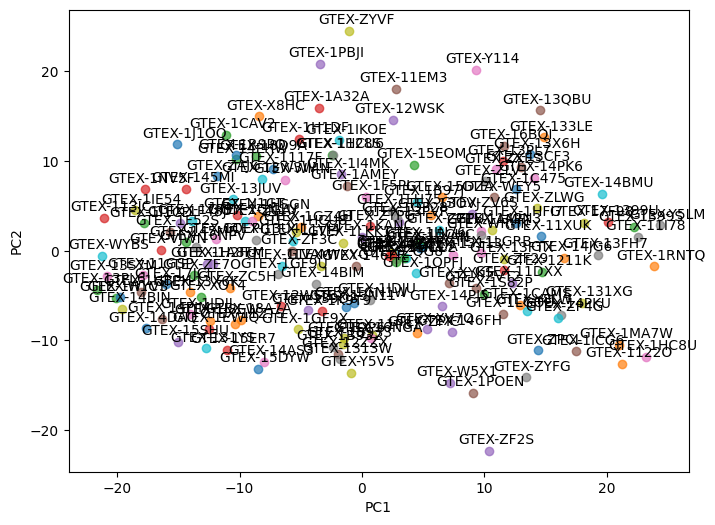

In [67]:
# Run pca on feature selection outcome
principalComponents = run_PCA(df=female_norm_counts_df_log1p_filtered, standardize=True, n_components=2, 
                              metadata = female_metadata_VAT,
                              plot_title=None,
                              save_dir = None)

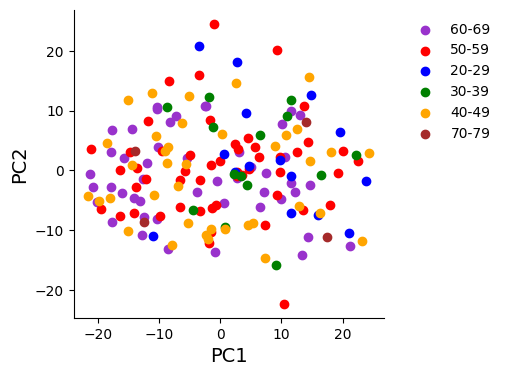

In [68]:
# Plot PCA plot and color the dots by group
groups = create_groups(metadata = female_metadata_VAT, 
                       col = 'AGE', 
                       Components=principalComponents)

plt.figure(figsize=(4, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

plt.savefig(classification_savedir + 'Female/Data_filtration_figures/3_PCA_normalized_GTEx_after_feature_selection.pdf', bbox_inches='tight')
plt.show()

# Dimension reduction
To reduce the dimensionality of the dataset, we employed RDA (Regularized Discriminant Analysis). Optional feature selection (highly variable gene selection) step with VMR and Mean expression can be performed before this if needed.

Shrinkage parameter of run_RDA function can be tuned to achieve best outcome.

921 features are kept after NaN Removal
Running RDA with n_components=2 and shrinkage=0.5


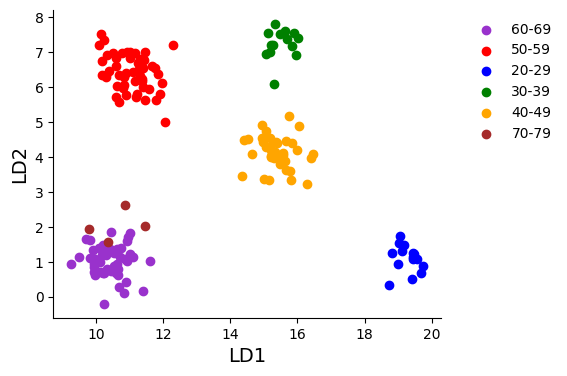

In [69]:
# run RDA
female_X_r2, female_rda = run_RDA(df=female_norm_counts_df_log1p_filtered, standardize=False, n_components=2, 
                                  metadata = female_metadata_VAT, design_factor='AGE', shrinkage=0.5,
                                  plot_title=None,
                                  save_dir = None)

# Plot RDA plot and color the dots by group
groups = create_groups(metadata = female_metadata_VAT, 
                       col = 'AGE', 
                       Components=female_X_r2)

plt.figure(figsize=(5, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('LD1', fontsize=14)
plt.ylabel('LD2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

plt.savefig(classification_savedir + 'Female/Data_filtration_figures/3_RDA_normalized_GTEx_after_all_filtering.pdf', bbox_inches='tight')
plt.show()

In [70]:
# Save the RDA model
import joblib

female_rda_joblib_file = classification_savedir + 'Female/Models/rda_model.joblib'
joblib.dump(female_rda, female_rda_joblib_file)

['/Volumes/RNA_s2/Figure_2_outs/5_alternative_Final_VAT_Classification_model_with_GTEx/Female/Models/rda_model.joblib']

In [71]:
# save GTEx RDA transformed results
np.save(classification_savedir + 'Female/Models/GTEx_RDA_transformed_array_X_r2.npy', female_X_r2)

# Classifier training

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Determine learning samples
female_X = female_X_r2 # The LDA model that we trained previously when we visualize male_norm_counts_df_log1p_filtered
female_y = female_metadata_VAT['AGE']

# Use only 5 classes instead of 6 (merge '50-59' and '60-69' classes)
condition_mapping = {
    '20-29': '20-29',
    '30-39': '30-39',
    '40-49': '40-49',
    '50-59': '50-59',
    '60-69': '60-69',
    '70-79': '70-79'
}

female_y_condition = female_y.map(condition_mapping)

# Split the dataset into training and testing sets
female_X_train, female_X_test, female_y_train, female_y_test = train_test_split(female_X, female_y_condition, test_size=0.3, random_state=42)

female_X_train

array([[15.77522914,  3.61150424],
       [15.30123968,  3.95663391],
       [ 9.97666259,  0.62132443],
       [10.91595381,  7.01082419],
       [10.28406874,  6.28600806],
       [10.21998971,  1.47840451],
       [11.31063737,  6.30636614],
       [10.28308311,  6.36011395],
       [16.40536926,  3.98293998],
       [18.72329589,  0.33020218],
       [11.08945069,  1.14922402],
       [10.2489528 ,  0.68364898],
       [15.26473385,  7.20661559],
       [15.06355841,  4.74471731],
       [15.21433498,  4.18519933],
       [11.9062441 ,  5.8068107 ],
       [14.3634539 ,  3.46141856],
       [15.38945308,  4.02505157],
       [11.39240314,  6.01504397],
       [19.74270207,  0.87970708],
       [10.67627215,  0.27903419],
       [15.83871767,  7.18838814],
       [10.14670399,  7.52456486],
       [14.6609681 ,  4.07392626],
       [11.34573462,  6.52836896],
       [10.63187069,  6.0269671 ],
       [19.17801342,  1.48555724],
       [11.47399636,  7.00426272],
       [10.682038  ,

In [74]:
# Training with multiple models for comprehensive results
female_rf_accuracy, female_rf = train_and_evaluate_classifier(female_X_train, female_y_train, female_X_test, female_y_test, 
                                                              algorithm='random_forest', n_estimators=100, max_depth=10)


Accuracy of the classifier (random_forest): 0.9411764705882353


In [75]:
# Save the RF model
female_RF_joblib_file = classification_savedir + 'Female/Models/rf_classification_model.joblib'
joblib.dump(female_rf, female_RF_joblib_file)

['/Volumes/RNA_s2/Figure_2_outs/5_alternative_Final_VAT_Classification_model_with_GTEx/Female/Models/rf_classification_model.joblib']

In [76]:
# Save prediction accuracy
female_accuracy_df = pd.DataFrame()
female_accuracy_df['random forest'] = [female_rf_accuracy]

female_accuracy_df.to_excel(classification_savedir + 'Female/Models/Model_cross_validation_accuracies.xlsx')

In [77]:
# Predict on the entire dataset
female_prediction_results_df = pd.DataFrame(index=female_norm_counts_df_log1p.columns.tolist())

female_y_all_pred_rf = female_rf.predict(female_X)
female_prediction_results_df['rf_predicted_age'] = female_y_all_pred_rf

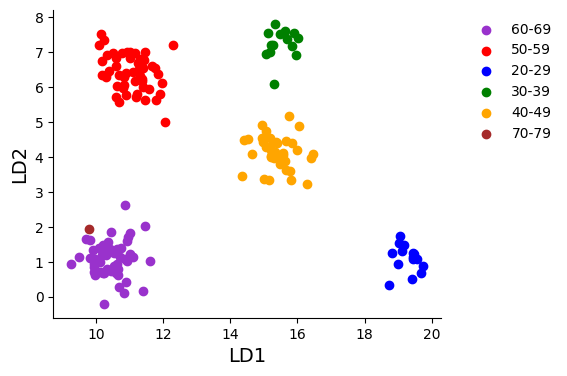

In [78]:
# Plot RDA plot and color the dots by group
groups = create_groups(metadata = female_prediction_results_df, 
                       col = 'rf_predicted_age', 
                       Components=female_X_r2)


plt.figure(figsize=(5, 4))

# Define a color for each group
group_colors = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=1, label=label, c=color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('LD1', fontsize=14)
plt.ylabel('LD2', fontsize=14)

legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_edgecolor('white')  

plt.savefig(classification_savedir + 'Female/Classifier_output_figures/1_RF_GTEx_female_all_datapoint_classification_prediction_results.pdf', bbox_inches='tight')
plt.show()

# Save male and female norm_counts_df_log1p

In [79]:
# Save male and female norm_counts_df_log1p_filtered
female_norm_counts_df_log1p_filtered.to_excel(classification_savedir + 'Female/Models/GTEx_female_norm_counts_df_log1p_filtered.xlsx')
male_norm_counts_df_log1p_filtered.to_excel(classification_savedir + 'Male/Models/GTEx_male_norm_counts_df_log1p_filtered.xlsx')

# Apply the model to our iADIPO-MPS RNA-seq data

1. Male serum treated samples + control of the corresponding batch(es)

In [80]:
robust_serum_4day_normalized_counts_df

,MY1_1,MY1_2,MY1_3,MY1_ctrl,Fat_OM1_1,Fat_OM1_2,Fat_OM1_3,YF1_1,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
RNA5SP292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SNORD115-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SNORD115-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MIR3116-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MLECP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDFI,1682.921557,1698.575818,1551.779659,706.022683,1950.300128,1721.453563,1713.085583,788.488847,1218.434907,982.5561,529.185041,1192.073946,1186.478833,1308.591727,944.521497,1296.948552,1007.376507,821.923927
NMUR2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,2.513943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LINC00431,1.377186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.169323,0.0000,0.000000,0.000000,0.876924,0.000000,1.487435,0.000000,0.000000,0.000000
RNU4-80P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.001218,0.000000,0.000000,0.000000,0.000000


In [81]:
# Read in metadata
Normalized_counts_save_dir = '/Volumes/RNA_s2/Figure_2_outs/Count/1_Normalized_Counts/'

iADIPO_metadata = pd.read_excel(Normalized_counts_save_dir + 'metadata.xlsx')
iADIPO_metadata = NameRows_Gene(iADIPO_metadata)
iADIPO_metadata

,condition,sex,age,batch
Unnamed: 0,,,,
MY1_1,Male_Young,Male,Young,Batch_1
MY1_2,Male_Young,Male,Young,Batch_1
MY1_3,Male_Young,Male,Young,Batch_1
MY1_ctrl,Control,Control,Control,Batch_1
Fat_OM1_1,Male_Old,Male,Old,Batch_1
Fat_OM1_2,Male_Old,Male,Old,Batch_1
Fat_OM1_3,Male_Old,Male,Old,Batch_1
YF1_1,Female_Young,Female,Young,Batch_2
YF1_Ctrl,Control,Control,Control,Batch_2


In [82]:
# Logarithmize the data
iADIPO_counts_df_log1p = robust_serum_4day_normalized_counts_df.apply(np.log1p)
iADIPO_counts_df_log1p

,MY1_1,MY1_2,MY1_3,MY1_ctrl,Fat_OM1_1,Fat_OM1_2,Fat_OM1_3,YF1_1,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
RNA5SP292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
SNORD115-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
SNORD115-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
MIR3116-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
MLECP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDFI,7.428881,7.438134,7.347802,6.561063,7.576251,7.451505,7.446635,6.671386,7.106143,6.891175,6.273226,7.084288,7.079588,7.177471,6.851737,7.16854,6.916097,6.712864
NMUR2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.256739,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
LINC00431,0.865918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.774415,0.000000,0.000000,0.000000,0.629635,0.000000,0.911252,0.00000,0.000000,0.000000
RNU4-80P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693756,0.000000,0.00000,0.000000,0.000000


In [83]:
# Extract male data
male_iADIPO_samples = ['MY1_1', 'MY1_2', 'MY1_3', 'MY1_ctrl', 'Fat_OM1_1', 'Fat_OM1_2', 'Fat_OM1_3']
male_iADIPO_counts_df_log1p = iADIPO_counts_df_log1p[male_iADIPO_samples]
male_iADIPO_counts_df_log1p = male_iADIPO_counts_df_log1p.fillna(0)
male_iADIPO_counts_df_log1p = male_iADIPO_counts_df_log1p.drop_duplicates()

# Further remove duplicated indexes
duplicate_indices = male_iADIPO_counts_df_log1p.index[male_iADIPO_counts_df_log1p.index.duplicated(keep=False)]
male_iADIPO_counts_df_log1p = male_iADIPO_counts_df_log1p[~male_iADIPO_counts_df_log1p.index.isin(duplicate_indices)]

# Extract the selected genes 
genes_to_keep = male_norm_counts_df_log1p_filtered.index.tolist()

# Create an empty DataFrame with the same columns as male_iADIPO_counts_df_log1p but with index = genes_to_keep
male_columns = male_iADIPO_counts_df_log1p.columns
male_iADIPO_counts_df_log1p_filtered = pd.DataFrame(0, index=genes_to_keep, columns=male_columns, dtype=float)

# Iterate through the rows of male_iADIPO_counts_df_log1p and add data to the new DataFrame
for gene in male_iADIPO_counts_df_log1p_filtered.index:
    print(gene)
    if gene in male_iADIPO_counts_df_log1p.index:
        male_iADIPO_counts_df_log1p_filtered.loc[gene] = male_iADIPO_counts_df_log1p.loc[gene].tolist()
    else:
        male_iADIPO_counts_df_log1p_filtered.loc[gene] = 0

# Check the shape of the resulting DataFrame
print(male_iADIPO_counts_df_log1p_filtered.shape)

male_iADIPO_counts_df_log1p_filtered

SPDYE21P
RRP12
PCDHA12
BTG3
GTF2IP7
FBXO6
TCF7
SYPL2
NTSR2
ST13P6
PLIN4
B3GAT3P1
LY6E
DRAIC
SQLE
DHRS2
GTF2H2
SGMS2
NAT14
PDPK2P
ZAN
FGFRL1
HIVEP3
CHI3L1
UQCRQ
CHRM4
SLC44A3
EFCAB5
GABRB1
POU5F1B
LINC01336
CKS2
LEXM
MSNP1
CELF4
AC079466.1
CASP7
INSC
MIR1254-1
VWA5B1
ISOC1
SOX30
WNT5B
MTRNR2L3
LINC00466
SPEF1
RPL15P2
RNF223
UGT2B17
PNMA6B
CYP2J2
TIAM2
COL4A1
HK2
ZDHHC2
SLC7A5
MLNR
PCK2
ATXN2-AS
DPPA4
YWHAZP3
ARPP21
RMND1
FABP5P1
GCOM2
OPRD1
ABCC6P1
NANOS1
SYCE3
SOX9-AS1
HOXC-AS1
LURAP1L-AS1
SLC8A1-AS1
MNX1
C1QL2
UAP1L1
RN7SKP269
MRAS
CYSTM1
TMEM40
HIST1H4D
IFIT1B
TRIM31-AS1
ZNF233
TSPAN13
RPP40
RPSAP29
INSM1
VTI1BP2
CRISPLD1
UBE2U
GMNN
SCO1
GADD45G
FAM83H
NPSR1-AS1
RNU6-510P
SPATA4
GYG2P1
DDX60L
FABP9
PLA2G16
VDAC1P2
CPA5
INHBA-AS1
SCG2
DMRTA2
ATP13A3
OGFRP1
OAS2
LINC01914
PPP1R1B
TMEM262
PCCB
LINC01198
RPL10P13
LINC00643
LINC01629
SOS1
KRTAP1-5
TNK2-AS1
MGST1
BOLA2B
RNU1-106P
UROS
BANF1P3
RNU6-2
HMGCS1
PSMD14
S100A16
CBX3P9
BCAP31
USP2-AS1
SNRPGP15
ALG1L2
PGBD4P3
MIR616
TOMM40
INHBE
HN

,MY1_1,MY1_2,MY1_3,MY1_ctrl,Fat_OM1_1,Fat_OM1_2,Fat_OM1_3
SPDYE21P,0.000000,1.216582,1.402846,1.433815,1.400418,1.112534,1.661407
RRP12,7.309125,7.226717,7.499601,7.416556,7.319923,7.275680,7.324325
PCDHA12,3.249962,3.357444,2.505100,1.660048,1.624496,1.401942,1.845836
BTG3,7.232513,7.315345,7.371226,7.578184,7.688741,7.610136,7.581493
GTF2IP7,0.865918,0.949243,0.000000,0.725077,1.111177,0.000000,0.725943
...,...,...,...,...,...,...,...
HSPB8,8.543059,8.438668,8.297125,8.636056,8.512504,8.260134,8.168025
SLC35G6,0.000000,0.000000,0.704212,1.140963,1.400418,0.703606,1.142105
RN7SKP97,1.322921,2.424307,0.000000,2.134668,1.962036,1.626121,2.624679
MDFI,7.428881,7.438134,7.347802,6.561063,7.576251,7.451505,7.446635


In [84]:
# Apply the pre-trained RDA model to iADIPO male samples
male_iADIPO_rda = rda.transform(male_iADIPO_counts_df_log1p_filtered.T)

In [85]:
# save iADIPO (4 day serum treated) RDA transformed results
np.save(classification_savedir + 'Male/Models/male_iADIPO_RDA_transformed_array_male_iADIPO_rda.npy', male_iADIPO_rda)

In [86]:
male_iADIPO_counts_df_log1p_filtered.to_excel(classification_savedir + 'Male/Models/male_iADIPO_counts_df_log1p_filtered.xlsx')

In [87]:
# Predict on the RDA-transformed iADIPO male data
y_pred_iADIPO_rf = rf.predict(male_iADIPO_rda)

iADIPO_prediction_results_df = pd.DataFrame(index=male_iADIPO_counts_df_log1p_filtered.columns.tolist())
iADIPO_prediction_results_df['rf_predicted_age'] = y_pred_iADIPO_rf
iADIPO_prediction_results_df['condition'] = ['Male Young']*3 + ['Control'] + ['Male Old']*3
iADIPO_prediction_results_df

,rf_predicted_age,condition
MY1_1,60-69,Male Young
MY1_2,60-69,Male Young
MY1_3,40-49,Male Young
MY1_ctrl,50-59,Control
Fat_OM1_1,60-69,Male Old
Fat_OM1_2,50-59,Male Old
Fat_OM1_3,50-59,Male Old


In [88]:
# Save prediction results
iADIPO_prediction_results_df.to_excel(classification_savedir + 'Male/iADIPO_male_samples_prediction_results.xlsx')

/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/2273289652.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color_label = iADIPO_prediction_results_df.rf_predicted_age[i]
/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/2273289652.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(iADIPO_prediction_results_df.condition[i],  # Annotate with the condition


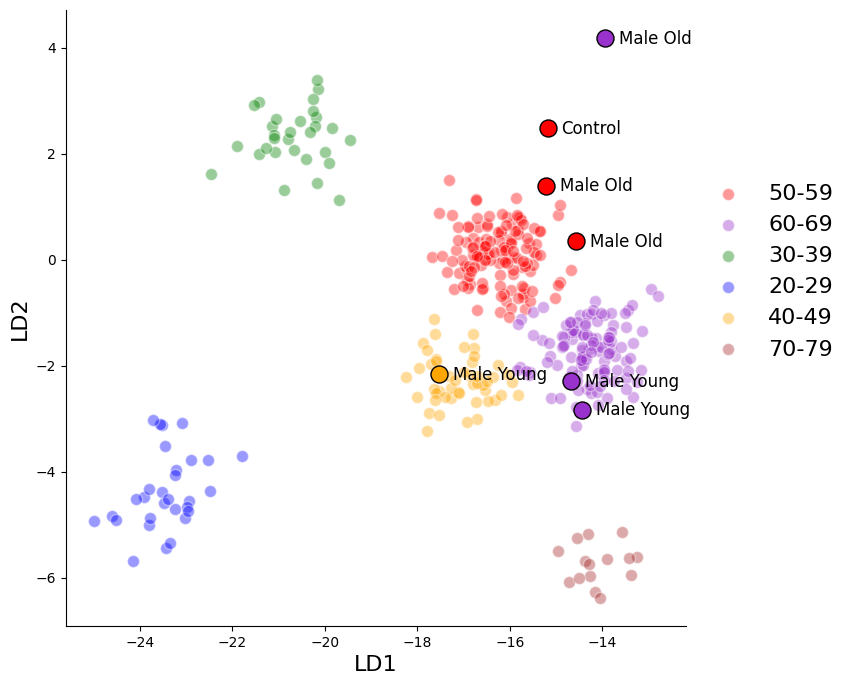

In [89]:
# Plot RDA plot and color the dots by group
groups_GTEx = create_groups(metadata = prediction_results_df, 
                            col = 'rf_predicted_age', 
                            Components=X_r2)

# groups for iADIPO prediction results
groups_iADIPO = create_groups(metadata = iADIPO_prediction_results_df, 
                              col = 'condition', 
                              Components=male_iADIPO_rda)
    
    
plt.figure(figsize=(8, 8))

# Define a color for each group
group_colors_GTEx = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}
group_colors_iADIPO = {'Male Young': 'Steelblue', 'Control': 'silver', 'Male Old': 'Orangered'}

for label, group in groups_GTEx.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors_GTEx[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=0.4, label=label, c=color, s=75, edgecolors='white')
    
legend=plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', fontsize=16)
legend.get_frame().set_edgecolor('white')  # Change 'red' to your desired color

for i, index in enumerate(iADIPO_prediction_results_df.index):
    point = male_iADIPO_rda[i]
    color_label = iADIPO_prediction_results_df.rf_predicted_age[i]
    color = group_colors_GTEx[color_label]
    plt.scatter(point[0], point[1], alpha=1, label=color_label, c=color, s=150, edgecolors='black')
    # Annotate each point
    plt.annotate(iADIPO_prediction_results_df.condition[i],  # Annotate with the condition
                     (point[0], point[1]), 
                     textcoords="offset points",  
                     xytext=(10, -4),
                     ha='left',
                     fontsize=12,
                     fontweight=500
                     )
    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('LD1', fontsize=16)
plt.ylabel('LD2', fontsize=16)

plt.savefig(classification_savedir + 'Male/Classifier_output_figures/2_RF_male_iADIPO_prediction_result_figure_narrow.pdf', bbox_inches='tight')
plt.show()

2. female serum treated samples and corresponding control(s) of the batch(es)

In [90]:
iADIPO_counts_df_log1p

,MY1_1,MY1_2,MY1_3,MY1_ctrl,Fat_OM1_1,Fat_OM1_2,Fat_OM1_3,YF1_1,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
RNA5SP292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
SNORD115-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
SNORD115-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
MIR3116-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
MLECP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDFI,7.428881,7.438134,7.347802,6.561063,7.576251,7.451505,7.446635,6.671386,7.106143,6.891175,6.273226,7.084288,7.079588,7.177471,6.851737,7.16854,6.916097,6.712864
NMUR2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.256739,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
LINC00431,0.865918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.774415,0.000000,0.000000,0.000000,0.629635,0.000000,0.911252,0.00000,0.000000,0.000000
RNU4-80P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693756,0.000000,0.00000,0.000000,0.000000


In [91]:
# Extract female data
female_iADIPO_samples = ['YF1_1','YF1_Ctrl','OF1_1','OF1_4','OF1_FY2_ctrl','OF2_1','OF2_2','OF2_4','OF2_ctrl','FY2_1','FY2_3']
female_iADIPO_counts_df_log1p = iADIPO_counts_df_log1p[female_iADIPO_samples]
female_iADIPO_counts_df_log1p = female_iADIPO_counts_df_log1p.fillna(0)
female_iADIPO_counts_df_log1p = female_iADIPO_counts_df_log1p.drop_duplicates()

# Extract the selected genes 
genes_to_keep = female_norm_counts_df_log1p_filtered.index.tolist()

# Create an empty DataFrame with the same columns as male_iADIPO_counts_df_log1p but with index = genes_to_keep
female_columns = female_iADIPO_counts_df_log1p.columns
female_iADIPO_counts_df_log1p_filtered = pd.DataFrame(0, index=genes_to_keep, columns=female_columns, dtype=float)

# Iterate through the rows of male_iADIPO_counts_df_log1p and add data to the new DataFrame
for gene in female_iADIPO_counts_df_log1p_filtered.index:
    print(gene)
    if gene in female_iADIPO_counts_df_log1p.index:
        female_iADIPO_counts_df_log1p_filtered.loc[gene] = female_iADIPO_counts_df_log1p.loc[gene].tolist()
    else:
        female_iADIPO_counts_df_log1p_filtered.loc[gene] = 0

# Check the shape of the resulting DataFrame
print(female_iADIPO_counts_df_log1p_filtered.shape)

female_iADIPO_counts_df_log1p_filtered

SPDYE21P
RRP12
PCDHA12
BTG3
GTF2IP7
FBXO6
TCF7
SYPL2
NTSR2
ST13P6
PLIN4
LY6E
DRAIC
SQLE
DHRS2
GTF2H2
SGMS2
NAT14
PDPK2P
ZAN
ZIC4
FGFRL1
HIVEP3
CHI3L1
UQCRQ
CHRM4
SLC44A3
EFCAB5
GABRB1
POU5F1B
LINC01336
CKS2
LEXM
MSNP1
CELF4
AC079466.1
CASP7
INSC
MIR1254-1
VWA5B1
ISOC1
SOX30
WNT5B
MTRNR2L3
LINC00466
SPEF1
RPL15P2
RNF223
UGT2B17
PNMA6B
CYP2J2
TIAM2
COL4A1
HK2
ZDHHC2
SLC7A5
MLNR
PCK2
ATXN2-AS
DPPA4
YWHAZP3
ARPP21
RMND1
FABP5P1
GCOM2
SLC22A9
OPRD1
ABCC6P1
NANOS1
SYCE3
SOX9-AS1
HOXC-AS1
LURAP1L-AS1
SLC8A1-AS1
MNX1
C1QL2
UAP1L1
RN7SKP269
MRAS
CYSTM1
TMEM40
HIST1H4D
IFIT1B
TRIM31-AS1
ZNF233
TSPAN13
RPP40
RPSAP29
INSM1
VTI1BP2
CRISPLD1
UBE2U
GMNN
SCO1
GADD45G
FAM83H
NPSR1-AS1
RNU6-510P
SPATA4
DDX60L
FABP9
PLA2G16
VDAC1P2
CPA5
INHBA-AS1
SCG2
DMRTA2
ATP13A3
OGFRP1
OAS2
LINC01914
PPP1R1B
TMEM262
PCCB
LINC01198
LINC00643
LINC01629
SOS1
KRTAP1-5
TNK2-AS1
MGST1
BOLA2B
RNU1-106P
UROS
BANF1P3
RNU6-2
HMGCS1
PSMD14
S100A16
CBX3P9
BCAP31
USP2-AS1
SNRPGP15
ALG1L2
PGBD4P3
MIR616
TOMM40
INHBE
HNF4G
CTSA
RHO

,YF1_1,YF1_Ctrl,OF1_1,OF1_4,OF1_FY2_ctrl,OF2_1,OF2_2,OF2_4,OF2_ctrl,FY2_1,FY2_3
SPDYE21P,1.346282,0.000000,1.906809,1.256739,1.740573,1.505787,1.610412,0.556019,0.733615,0.000000,1.600662
RRP12,7.272788,7.502342,7.356624,7.681569,7.527622,7.038893,7.296273,7.467499,6.881671,7.351991,7.679766
PCDHA12,2.589277,2.629191,2.756100,2.510635,2.650541,3.456076,2.709186,3.116525,3.211532,3.160056,2.762297
BTG3,7.518817,7.652442,7.678699,7.708454,7.684150,7.121527,7.375845,7.450356,7.226860,7.490457,7.523252
GTF2IP7,0.666651,0.774415,0.598175,1.562538,1.057875,0.000000,0.000000,0.556019,0.000000,1.255044,1.378069
...,...,...,...,...,...,...,...,...,...,...,...
HSPB8,8.142186,8.330806,8.204602,8.112075,8.281823,8.319963,8.413272,8.411446,8.483816,8.080638,7.904005
SLC35G6,0.666651,1.505847,0.598175,1.256739,0.000000,1.965499,0.693756,0.000000,1.152213,1.255044,1.091304
RN7SKP97,1.063125,0.000000,1.777116,0.814024,0.000000,2.365200,2.198307,2.132648,2.374287,1.255044,0.687671
MDFI,6.671386,7.106143,6.891175,6.273226,7.084288,7.079588,7.177471,6.851737,7.168540,6.916097,6.712864


In [92]:
female_iADIPO_counts_df_log1p_filtered.to_excel(classification_savedir + 'Female/Models/female_iADIPO_counts_df_log1p_filtered.xlsx')

In [93]:
# Apply the pre-trained RDA model to iADIPO male samples
female_iADIPO_rda = female_rda.transform(female_iADIPO_counts_df_log1p_filtered.T)

In [94]:
# save iADIPO (4 day serum treated) female RDA transformed results
np.save(classification_savedir + 'Female/Models/female_iADIPO_RDA_transformed_array_female_iADIPO_rda.npy', female_iADIPO_rda)

In [95]:
# Predict on the RDA-transformed iADIPO female data
female_y_pred_iADIPO_rf = female_rf.predict(female_iADIPO_rda)

female_iADIPO_prediction_results_df = pd.DataFrame(index=female_iADIPO_counts_df_log1p_filtered.columns.tolist())
female_iADIPO_prediction_results_df['rf_predicted_age'] = female_y_pred_iADIPO_rf
female_iADIPO_prediction_results_df['condition'] = ['Female Young']+['Control']+['Female Old']*2+['Control']+['Female Old']*3+['Control']+['Female Young']*2
female_iADIPO_prediction_results_df

,rf_predicted_age,condition
YF1_1,50-59,Female Young
YF1_Ctrl,50-59,Control
OF1_1,70-79,Female Old
OF1_4,60-69,Female Old
OF1_FY2_ctrl,60-69,Control
OF2_1,50-59,Female Old
OF2_2,40-49,Female Old
OF2_4,40-49,Female Old
OF2_ctrl,50-59,Control
FY2_1,50-59,Female Young


In [96]:
# Save prediction results
female_iADIPO_prediction_results_df.to_excel(classification_savedir + 'Female/iADIPO_female_samples_prediction_results.xlsx')

/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/1346008868.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color_label = female_iADIPO_prediction_results_df.rf_predicted_age[i]
/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/1346008868.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(female_iADIPO_prediction_results_df.condition[i],  # Annotate with the condition


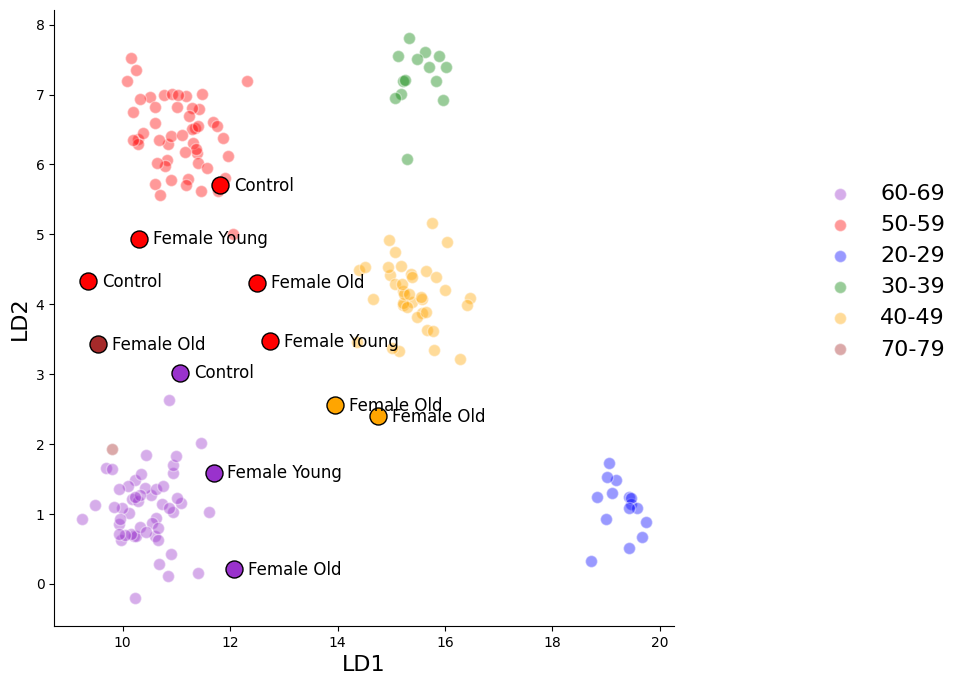

In [97]:
# Plot RDA plot and color the dots by group
groups_GTEx = create_groups(metadata = female_prediction_results_df, 
                            col = 'rf_predicted_age', 
                            Components=female_X_r2)
    
    
plt.figure(figsize=(8, 8))

# Define a color for each group
group_colors_GTEx = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups_GTEx.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors_GTEx[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=0.4, label=label, c=color, s=75, edgecolors='white')
    
legend=plt.legend(bbox_to_anchor=(1.2, 0.75), loc='upper left', fontsize=16)
legend.get_frame().set_edgecolor('white')  # Change 'red' to your desired color

for i, index in enumerate(female_iADIPO_prediction_results_df.index):
    point = female_iADIPO_rda[i]
    color_label = female_iADIPO_prediction_results_df.rf_predicted_age[i]
    color = group_colors_GTEx[color_label]
    plt.scatter(point[0], point[1], alpha=1, label=color_label, c=color, s=150, edgecolors='black')
    # Annotate each point
    plt.annotate(female_iADIPO_prediction_results_df.condition[i],  # Annotate with the condition
                     (point[0], point[1]), 
                     textcoords="offset points",  
                     xytext=(10, -4),
                     ha='left',
                     fontsize=12,
                     fontweight=500
                     )
    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('LD1', fontsize=16)
plt.ylabel('LD2', fontsize=16)

plt.savefig(classification_savedir + 'Female/Classifier_output_figures/2_RF_female_iADIPO_prediction_result_figure_square.pdf', bbox_inches='tight')
plt.show()

3. Apply the male model to 8 day serum treated WAT-MPS

In [98]:
# Read in normalized counts of 
eight_days_counts_save_dir = '/Volumes/RNA_s2/Figure_5_outs/Count/'
eight_days_all_counts_df = pd.read_excel(eight_days_counts_save_dir + 'gene_count.xlsx')
eight_days_all_counts_df = NameRows_Gene(eight_days_all_counts_df)

gene_info_df = pd.read_excel(eight_days_counts_save_dir + 'gene_info.xlsx')

eight_days_all_counts_df.index = gene_info_df['gene_name'] # rename with official gene symbol
eight_days_all_counts_df

,Ctrl1,Ctrl2,Ctrl3,YY1,YY2,YY3,YO1,YO2,YO3,OY1,OY2,OY3,OO1,OO2,OO3,OY3_1
gene_name,,,,,,,,,,,,,,,,
FTL,970895,1034423,892501,1388047,775924,1378575,1729652,764418,755015,653410,710859,1068922,606887,694409,1285837,643450
SCD,758995,707989,456631,993534,744140,453454,1340891,932497,524513,321366,223514,387925,283468,179527,109249,84742
FABP4,397757,407701,277218,542059,375946,627593,536999,329452,370540,505930,372928,596140,378280,335368,297210,221021
GPX3,257058,190297,237187,238826,194299,287884,269345,185926,162489,96671,161762,219418,115855,162083,335091,222987
MT-RNR2,125932,121490,69583,268364,179351,153891,273472,171583,153661,160245,155205,239391,136164,113602,120411,66433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF01973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RF01974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AC233755.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [99]:
from pydeseq2.preprocessing import deseq2_norm

serum_8day_norm = deseq2_norm(eight_days_all_counts_df.T)
normalized_eight_days_df = serum_8day_norm[0].T
normalized_eight_days_df

,Ctrl1,Ctrl2,Ctrl3,YY1,YY2,YY3,YO1,YO2,YO3,OY1,OY2,OY3,OO1,OO2,OO3,OY3_1
gene_name,,,,,,,,,,,,,,,,
FTL,1.220955e+06,1.141922e+06,1.031176e+06,1.403261e+06,884835.330174,1.211055e+06,1.827006e+06,9.833186e+05,851478.416221,678235.091780,575153.696013,687657.385389,602736.162799,652354.523499,866590.445087,604713.349135
SCD,9.544785e+05,7.815641e+05,5.275813e+05,1.004424e+06,848590.019893,3.983516e+05,1.416364e+06,1.199529e+06,591526.656461,333575.700563,180844.447648,249559.360952,281529.204936,168654.568907,73628.414438,79640.405055
FABP4,5.002016e+05,4.500698e+05,3.202915e+05,5.480002e+05,428715.058482,5.513297e+05,5.672242e+05,4.237947e+05,417881.515396,525151.864808,301734.827226,383507.939518,375692.733019,315057.598385,200304.817939,207715.205749
GPX3,3.232648e+05,2.100729e+05,2.740406e+05,2.414436e+05,221571.468104,2.529012e+05,2.845052e+05,2.391682e+05,183249.175677,100343.833975,130881.106063,141155.676642,115062.603320,152267.004362,225834.735534,209562.849613
MT-RNR2,1.583665e+05,1.341154e+05,8.039464e+04,2.713054e+05,204525.316013,1.351906e+05,2.888645e+05,2.207179e+05,173293.278829,166333.209290,125575.858770,154004.678682,135232.698791,106722.088248,81151.049537,62433.634196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF01973,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RF01974,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC233755.2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [100]:
# Read in metadata

eight_days_metadata = pd.read_excel(eight_days_counts_save_dir + '1_Normalized_Counts/metadata.xlsx')
eight_days_metadata = NameRows_Gene(eight_days_metadata)
eight_days_metadata

,condition
Unnamed: 0,
Ctrl1,Control
Ctrl2,Control
Ctrl3,Control
YY1,Iso_Young
YY2,Iso_Young
YY3,Iso_Young
YO1,Het_YO
YO2,Het_YO
YO3,Het_YO


In [101]:
# Logarithmize the data
eight_days_counts_df_log1p = normalized_eight_days_df.apply(np.log1p)
eight_days_counts_df_log1p

,Ctrl1,Ctrl2,Ctrl3,YY1,YY2,YY3,YO1,YO2,YO3,OY1,OY2,OY3,OO1,OO2,OO3,OY3_1
gene_name,,,,,,,,,,,,,,,,
FTL,14.015144,13.948224,13.846211,14.154310,13.693158,14.007003,14.418190,13.798689,13.654731,13.427251,13.262394,13.441047,13.309236,13.388345,13.672323,13.312511
SCD,13.768921,13.569054,13.176060,13.819925,13.651333,12.895093,14.163604,13.997440,13.290464,12.717628,12.105398,12.427456,12.547995,12.035614,11.206800,11.285289
FABP4,13.122769,13.017160,12.676990,13.214033,12.968550,13.220090,13.248512,12.957007,12.942956,13.171445,12.617307,12.857118,12.836530,12.660514,12.207601,12.243928
GPX3,12.686230,12.255215,12.521035,12.394395,12.308505,12.440758,12.558510,12.384927,12.118608,11.516368,11.782052,11.857626,11.653240,11.933397,12.327563,12.252784
MT-RNR2,11.972674,11.806463,11.294715,12.511004,12.228452,11.814448,12.573716,12.304645,12.062746,12.021754,11.740673,11.944745,11.814760,11.577993,11.304080,11.041875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF01973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RF01974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC233755.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [102]:
# Preproess the data (all serum donors in this batch are male)

eight_days_counts_df_log1p = eight_days_counts_df_log1p.fillna(0)
processed_eight_days_counts_df_log1p = eight_days_counts_df_log1p.drop_duplicates()

# Further remove duplicated indexes
duplicate_indices = processed_eight_days_counts_df_log1p.index[processed_eight_days_counts_df_log1p.index.duplicated(keep=False)]
processed_eight_days_counts_df_log1p = processed_eight_days_counts_df_log1p[~processed_eight_days_counts_df_log1p.index.isin(duplicate_indices)]

# Extract the selected genes 
genes_to_keep = male_norm_counts_df_log1p_filtered.index.tolist()

# Create an empty DataFrame with the same columns as male_iADIPO_counts_df_log1p but with index = genes_to_keep
male_columns = processed_eight_days_counts_df_log1p.columns
processed_eight_days_counts_df_log1p_filtered = pd.DataFrame(0, index=genes_to_keep, columns=male_columns, dtype=float)

# Iterate through the rows of male_iADIPO_counts_df_log1p and add data to the new DataFrame
for gene in processed_eight_days_counts_df_log1p_filtered.index:
    print(gene)
    if gene in processed_eight_days_counts_df_log1p.index:
        processed_eight_days_counts_df_log1p_filtered.loc[gene] = processed_eight_days_counts_df_log1p.loc[gene].tolist()
    else:
        processed_eight_days_counts_df_log1p_filtered.loc[gene] = 0

# Check the shape of the resulting DataFrame
print(processed_eight_days_counts_df_log1p_filtered.shape)

processed_eight_days_counts_df_log1p_filtered

SPDYE21P
RRP12
PCDHA12
BTG3
GTF2IP7
FBXO6
TCF7
SYPL2
NTSR2
ST13P6
PLIN4
B3GAT3P1
LY6E
DRAIC
SQLE
DHRS2
GTF2H2
SGMS2
NAT14
PDPK2P
ZAN
FGFRL1
HIVEP3
CHI3L1
UQCRQ
CHRM4
SLC44A3
EFCAB5
GABRB1
POU5F1B
LINC01336
CKS2
LEXM
MSNP1
CELF4
AC079466.1
CASP7
INSC
MIR1254-1
VWA5B1
ISOC1
SOX30
WNT5B
MTRNR2L3
LINC00466
SPEF1
RPL15P2
RNF223
UGT2B17
PNMA6B
CYP2J2
TIAM2
COL4A1
HK2
ZDHHC2
SLC7A5
MLNR
PCK2
ATXN2-AS
DPPA4
YWHAZP3
ARPP21
RMND1
FABP5P1
GCOM2
OPRD1
ABCC6P1
NANOS1
SYCE3
SOX9-AS1
HOXC-AS1
LURAP1L-AS1
SLC8A1-AS1
MNX1
C1QL2
UAP1L1
RN7SKP269
MRAS
CYSTM1
TMEM40
HIST1H4D
IFIT1B
TRIM31-AS1
ZNF233
TSPAN13
RPP40
RPSAP29
INSM1
VTI1BP2
CRISPLD1
UBE2U
GMNN
SCO1
GADD45G
FAM83H
NPSR1-AS1
RNU6-510P
SPATA4
GYG2P1
DDX60L
FABP9
PLA2G16
VDAC1P2
CPA5
INHBA-AS1
SCG2
DMRTA2
ATP13A3
OGFRP1
OAS2
LINC01914
PPP1R1B
TMEM262
PCCB
LINC01198
RPL10P13
LINC00643
LINC01629
SOS1
KRTAP1-5
TNK2-AS1
MGST1
BOLA2B
RNU1-106P
UROS
BANF1P3
RNU6-2
HMGCS1
PSMD14
S100A16
CBX3P9
BCAP31
USP2-AS1
SNRPGP15
ALG1L2
PGBD4P3
MIR616
TOMM40
INHBE
HN

,Ctrl1,Ctrl2,Ctrl3,YY1,YY2,YY3,YO1,YO2,YO3,OY1,OY2,OY3,OO1,OO2,OO3,OY3_1
SPDYE21P,0.000000,0.743803,1.726600,1.618168,1.902379,1.684993,1.653482,1.580851,2.185416,0.711966,0.592828,1.439027,1.094042,0.662398,0.853522,1.560078
RRP12,7.423453,6.910009,7.561927,7.094280,7.233745,6.719654,7.173541,7.285129,7.190014,7.060125,7.745423,7.612312,7.554782,7.728250,8.013780,7.984800
PCDHA12,2.988876,2.166473,2.206916,3.306336,2.605943,2.186764,2.535215,2.165410,3.293559,2.336207,1.618494,2.303231,1.940030,2.581178,2.206889,2.246881
BTG3,7.569224,7.875784,7.653141,7.525150,7.463636,7.668611,7.293935,7.051741,7.453839,8.260370,7.859455,7.851071,7.829114,7.889461,7.863949,7.879940
GTF2IP7,1.257071,1.461347,0.000000,1.955261,1.188065,0.630464,1.427642,1.273329,1.180354,0.000000,0.962485,1.581020,1.094042,0.662398,0.000000,1.057650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HSPB8,8.562391,8.273827,8.576469,8.257070,8.111671,7.994929,8.479166,8.245701,7.793407,8.447334,8.393410,8.585609,8.451006,8.489521,8.560137,8.303830
SLC35G6,1.257071,1.461347,0.000000,0.000000,1.188065,0.630464,0.000000,0.826962,0.755071,1.123626,0.962485,0.000000,0.000000,0.000000,1.743558,1.057650
RN7SKP97,2.923472,2.926529,1.496523,2.494904,2.686783,2.651638,2.535215,3.010396,2.507779,1.822930,1.896671,1.581020,1.381151,2.024994,0.853522,1.560078
MDFI,7.221997,6.478832,6.927600,7.223924,6.849003,7.082100,7.227142,7.098525,6.890896,6.187814,6.986523,7.091270,6.702450,6.964011,6.226119,6.180258


In [103]:
# Apply the pre-trained LDA model to iADIPO male samples
eight_days_rda = rda.transform(processed_eight_days_counts_df_log1p_filtered.T)

In [104]:
# Predict on the LDA-transformed iADIPO 8 days serum treated data
y_pred_eight_days = rf.predict(eight_days_rda)

eight_days_prediction_results_df = pd.DataFrame(index=processed_eight_days_counts_df_log1p_filtered.columns.tolist())
eight_days_prediction_results_df['rf_predicted_age'] = y_pred_eight_days
eight_days_prediction_results_df['condition'] = eight_days_metadata['condition']
eight_days_prediction_results_df

,rf_predicted_age,condition
Ctrl1,60-69,Control
Ctrl2,60-69,Control
Ctrl3,40-49,Control
YY1,60-69,Iso_Young
YY2,60-69,Iso_Young
YY3,60-69,Iso_Young
YO1,60-69,Het_YO
YO2,60-69,Het_YO
YO3,60-69,Het_YO
OY1,50-59,Het_OY


In [105]:
# Save prediction results
eight_days_prediction_results_df.to_excel(classification_savedir + 'Male/8_days_serum_treated_samples_prediction_results.xlsx')

/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/1399757097.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color_label = eight_days_prediction_results_df.rf_predicted_age[i]
/var/folders/31/r8m9xv997y94j__pk57t31l80000gn/T/ipykernel_7625/1399757097.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(eight_days_prediction_results_df.condition[i],  # Annotate with the condition


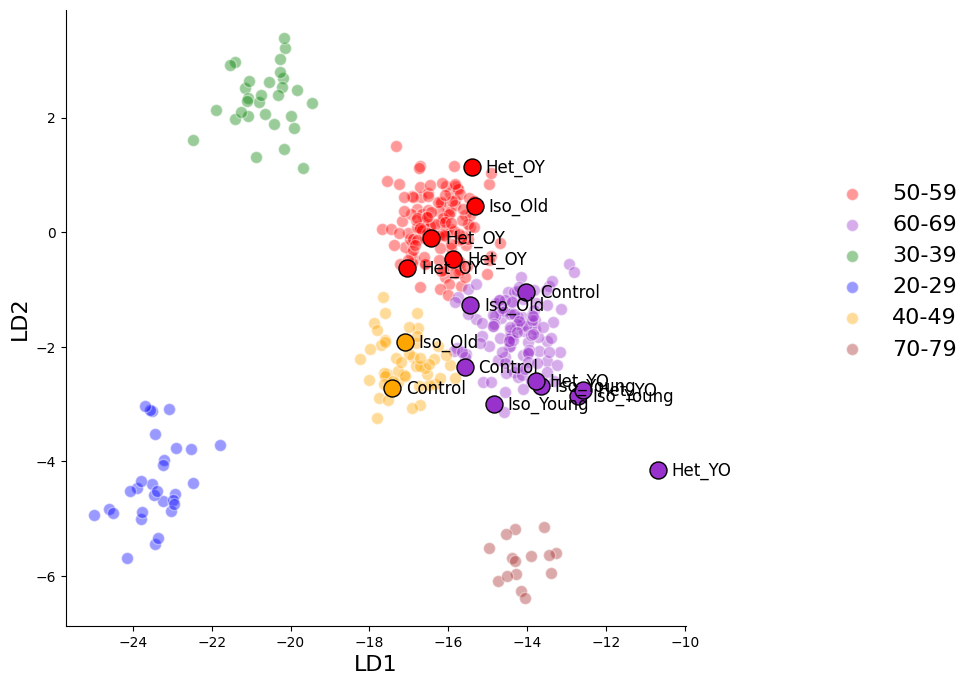

In [107]:
# Plot RDA plot and color the dots by group
groups_GTEx = create_groups(metadata = prediction_results_df, 
                            col = 'rf_predicted_age', 
                            Components=X_r2)
    
    
plt.figure(figsize=(8, 8))

# Define a color for each group
group_colors_GTEx = {'20-29':'blue', '30-39': 'green', '40-49': 'orange', '50-59': 'red', '60-69': 'darkorchid', '70-79': 'brown'}

for label, group in groups_GTEx.items():
    group = np.array(group)
    group = group[:,:2]
    color = group_colors_GTEx[label]
    
    # Scatter plot for the group
    plt.scatter(group[:, 0], group[:, 1], alpha=0.4, label=label, c=color, s=75, edgecolors='white')
    
legend=plt.legend(bbox_to_anchor=(1.2, 0.75), loc='upper left', fontsize=16)
legend.get_frame().set_edgecolor('white')  # Change 'red' to your desired color

for i, index in enumerate(eight_days_prediction_results_df.index):
    point = eight_days_rda[i]
    color_label = eight_days_prediction_results_df.rf_predicted_age[i]
    color = group_colors_GTEx[color_label]
    plt.scatter(point[0], point[1], alpha=1, label=color_label, c=color, s=150, edgecolors='black')
    # Annotate each point
    plt.annotate(eight_days_prediction_results_df.condition[i],  # Annotate with the condition
                     (point[0], point[1]), 
                     textcoords="offset points",  
                     xytext=(10, -4),
                     ha='left',
                     fontsize=12,
                     fontweight=500
                     )
    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('LD1', fontsize=16)
plt.ylabel('LD2', fontsize=16)

plt.savefig(classification_savedir + 'Male/Classifier_output_figures/4_RF_male_eight_days_prediction_result_figure_square.pdf', bbox_inches='tight')
plt.show()